## Data Loading

In [33]:
import psycopg2
import numpy as np
import pandas as pd
from getpass import getpass
from sqlalchemy import create_engine
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as st
from sklearn import ensemble, tree, linear_model
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, average_precision_score, roc_curve
from sklearn.calibration import calibration_curve
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, precision_recall_curve

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
hostname = 'spinup-db001ec7.cluster-c9ukc6s0rmbg.us-east-1.rds.amazonaws.com'
username = 'introml568'
password = 'm7bxMRtyMqPbcxyRRGML8'
database_name = 'urineculture'

In [4]:
# Connect using SQL Alchemy to support pandas mapping
alchemy_engine = create_engine(f"postgresql+psycopg2://{username}:{password}@{hostname}/{database_name}",  pool_recycle=3600)
db_connection = alchemy_engine.connect();

In [5]:
# search the name of datasets
query = """
SELECT table_name
FROM information_schema.tables
WHERE table_schema = 'public'
"""
datasets = pd.read_sql(query, db_connection)
# Get dataset
dat = pd.read_sql("select * from public.results", db_connection);

## Perform EDA

Getting a basic description of the data

In [6]:
dat.describe()

id         patid  UCX_abnormal         ua_ph  ua_spec_grav  \
count  80387.000000  80387.000000  80387.000000  80260.000000  80387.000000   
mean   40194.000000  27160.079602      0.227450      6.312428      1.019084   
std    23205.872382  16045.123111      0.419188      0.670796      0.018803   
min        1.000000      1.000000      0.000000      5.000000      0.018000   
25%    20097.500000  13267.500000      0.000000      6.000000      1.013000   
50%    40194.000000  26693.000000      0.000000      6.000000      1.018000   
75%    60290.500000  40826.500000      0.000000      6.500000      1.025000   
max    80387.000000  55365.000000      1.000000      9.000000      5.500000   

       CVA_tenderness  abd_tenderness  abd_soft  abd_distended  abd_gaurding  \
count    14624.000000    68135.000000   70622.0   47265.000000  41342.000000   
mean         0.242273        0.456461       1.0       0.086999      0.087877   
std          0.428473        0.498104       0.0       0.281836      0.283119   
min          0.000000        0.000000       1.0       0.000000      0.000000   
25%          0.000000        0.000000       1.0       0.000000      0.000000   
50%          0.000000        0.000000       1.0       0.000000      0.000000   
75%          0.000000        1.000000       1.0       0.000000      0.000000   
max          1.000000        1.000000       1.0       1.000000      1.000000   

       ...  psychotherapeutic_drugs  sedative_hypnotics    skin_preps  \
count  ...             80387.000000        80387.000000  80387.000000   
mean   ...                 0.374053            0.069165      0.111498   
std    ...                 0.483880            0.253737      0.314750   
min    ...                 0.000000            0.000000      0.000000   
25%    ...                 0.000000            0.000000      0.000000   
50%    ...                 0.000000            0.000000      0.000000   
75%    ...                 1.000000            0.000000      0.000000   
max    ...                 1.000000            1.000000      1.000000   

       smoking_deterrents  thyroid_preps  unclassified_drug_products  \
count        80387.000000   80387.000000                80387.000000   
mean             0.017913       0.122669                    0.195467   
std              0.132637       0.328059                    0.396562   
min              0.000000       0.000000                    0.000000   
25%              0.000000       0.000000                    0.000000   
50%              0.000000       0.000000                    0.000000   
75%              0.000000       0.000000                    0.000000   
max              1.000000       1.000000                    1.000000   

           vitamins      UTI_diag        abxUTI      alt_diag  
count  80387.000000  80387.000000  80387.000000  80387.000000  
mean       0.321333      0.213542      0.561670      0.056029  
std        0.466991      0.409810      0.496185      0.229979  
min        0.000000      0.000000      0.000000      0.000000  
25%        0.000000      0.000000      0.000000      0.000000  
50%        0.000000      0.000000      1.000000      0.000000  
75%        1.000000      0.000000      1.000000      0.000000  
max        1.000000      1.000000      1.000000      1.000000  

[8 rows x 183 columns]

We can have a overview of the dataset. The dataset has 80,387 records and 220 attributes.
Several columns appear to be binary indicators, with values of 0 or 1.
Some columns, like ua_ph, contain missing data, as their count is less than the total number of records.
Some columns may have outlier or incorrect values, like ua_spec_grav having a maximum value of 5.5, which is not typical for urine specific gravity.

Now we take a closer look at the data itself. 

In [7]:
dat.head()

id  patid  UCX_abnormal ua_bacteria   ua_bili  ua_blood ua_clarity  \
0   1      1             1         few  negative  negative      clear   
1   2      1             0        many  negative     small      clear   
2   3      2             1         few  negative  negative      clear   
3   4      3             1        many  negative  negative  not_clear   
4   5      4             0    moderate     small  negative      clear   

  ua_color ua_epi ua_glucose  ... skin_preps smoking_deterrents thyroid_preps  \
0   yellow  small   negative  ...          0                  0             0   
1   yellow   None   negative  ...          0                  0             0   
2   yellow  small   negative  ...          0                  0             1   
3   yellow   None   negative  ...          0                  0             0   
4   orange   None   negative  ...          0                  0             0   

   unclassified_drug_products vitamins      dispo  UTI_diag     split abxUTI  \
0                           0        0      Admit         1  training      1   
1                           0        1      Admit         1  training      1   
2                           1        0  Discharge         0  training      0   
3                           0        1      Admit         1  training      1   
4                           0        0        AMA         0  training      0   

   alt_diag  
0         0  
1         0  
2         0  
3         0  
4         0  

[5 rows x 220 columns]

In [8]:
dat.tail()

id  patid  UCX_abnormal ua_bacteria   ua_bili  ua_blood ua_clarity  \
80382  80383  55363             0    moderate  negative     large       None   
80383  80384  55363             1        none  negative     small  not_clear   
80384  80385  55364             0         few  negative  moderate      clear   
80385  80386  55364             1         few  negative  negative       None   
80386  80387  55365             1      marked     large     large       None   

      ua_color ua_epi ua_glucose  ... skin_preps smoking_deterrents  \
80382   yellow  small   negative  ...          1                  1   
80383   yellow  small   negative  ...          0                  0   
80384   yellow   None   negative  ...          0                  0   
80385   yellow  small   negative  ...          0                  0   
80386    other  small   negative  ...          0                  0   

      thyroid_preps  unclassified_drug_products vitamins      dispo  UTI_diag  \
80382             0                           1        0     Eloped         0   
80383             0                           0        0  Discharge         1   
80384             0                           0        0  Discharge         0   
80385             0                           1        1      Admit         0   
80386             1                           1        1      Admit         0   

            split abxUTI  alt_diag  
80382  validation      1         0  
80383  validation      1         0  
80384  validation      0         0  
80385  validation      1         0  
80386  validation      1         0  

[5 rows x 220 columns]

In [9]:
dat.shape

(80387, 220)

The dataset has 80,387 records and 220 attributes.

In [10]:
numeric_features = dat.select_dtypes(include=[np.number])
numeric_features.columns

Index(['id', 'patid', 'UCX_abnormal', 'ua_ph', 'ua_spec_grav',
       'CVA_tenderness', 'abd_tenderness', 'abd_soft', 'abd_distended',
       'abd_gaurding',
       ...
       'psychotherapeutic_drugs', 'sedative_hypnotics', 'skin_preps',
       'smoking_deterrents', 'thyroid_preps', 'unclassified_drug_products',
       'vitamins', 'UTI_diag', 'abxUTI', 'alt_diag'],
      dtype='object', length=183)

In [11]:
categorical_features = dat.select_dtypes(include=[np.object])
categorical_features.columns

C:\Users\wyr19\AppData\Local\Temp\ipykernel_27880\4027218164.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categorical_features = dat.select_dtypes(include=[np.object])


Index(['ua_bacteria', 'ua_bili', 'ua_blood', 'ua_clarity', 'ua_color',
       'ua_epi', 'ua_glucose', 'ua_ketones', 'ua_leuk', 'ua_nitrite',
       'ua_protein', 'ua_rbc', 'ua_urobili', 'ua_wbc', 'polyuria',
       'chief_complaint', 'gender', 'race', 'ethnicity', 'lang',
       'maritalStatus', 'employStatus', 'insurance_status', 'disposition',
       'arrival', 'O2_Dependency_First', 'O2_Dependency_Last',
       'Absolute_Lymphocyte_Count', 'Basophils', 'Eosinophils', 'Lymphocytes',
       'Monocytes', 'Neutrophils',
       'Diabetes_or_abnormal_glucose_tolerance_complicating_pregnancy__',
       'Screening_and_history_of_mental_health_and_substance_abuse_code',
       'dispo', 'split'],
      dtype='object')

Now we know how many features are numeric and how many are categorical.

<AxesSubplot:>

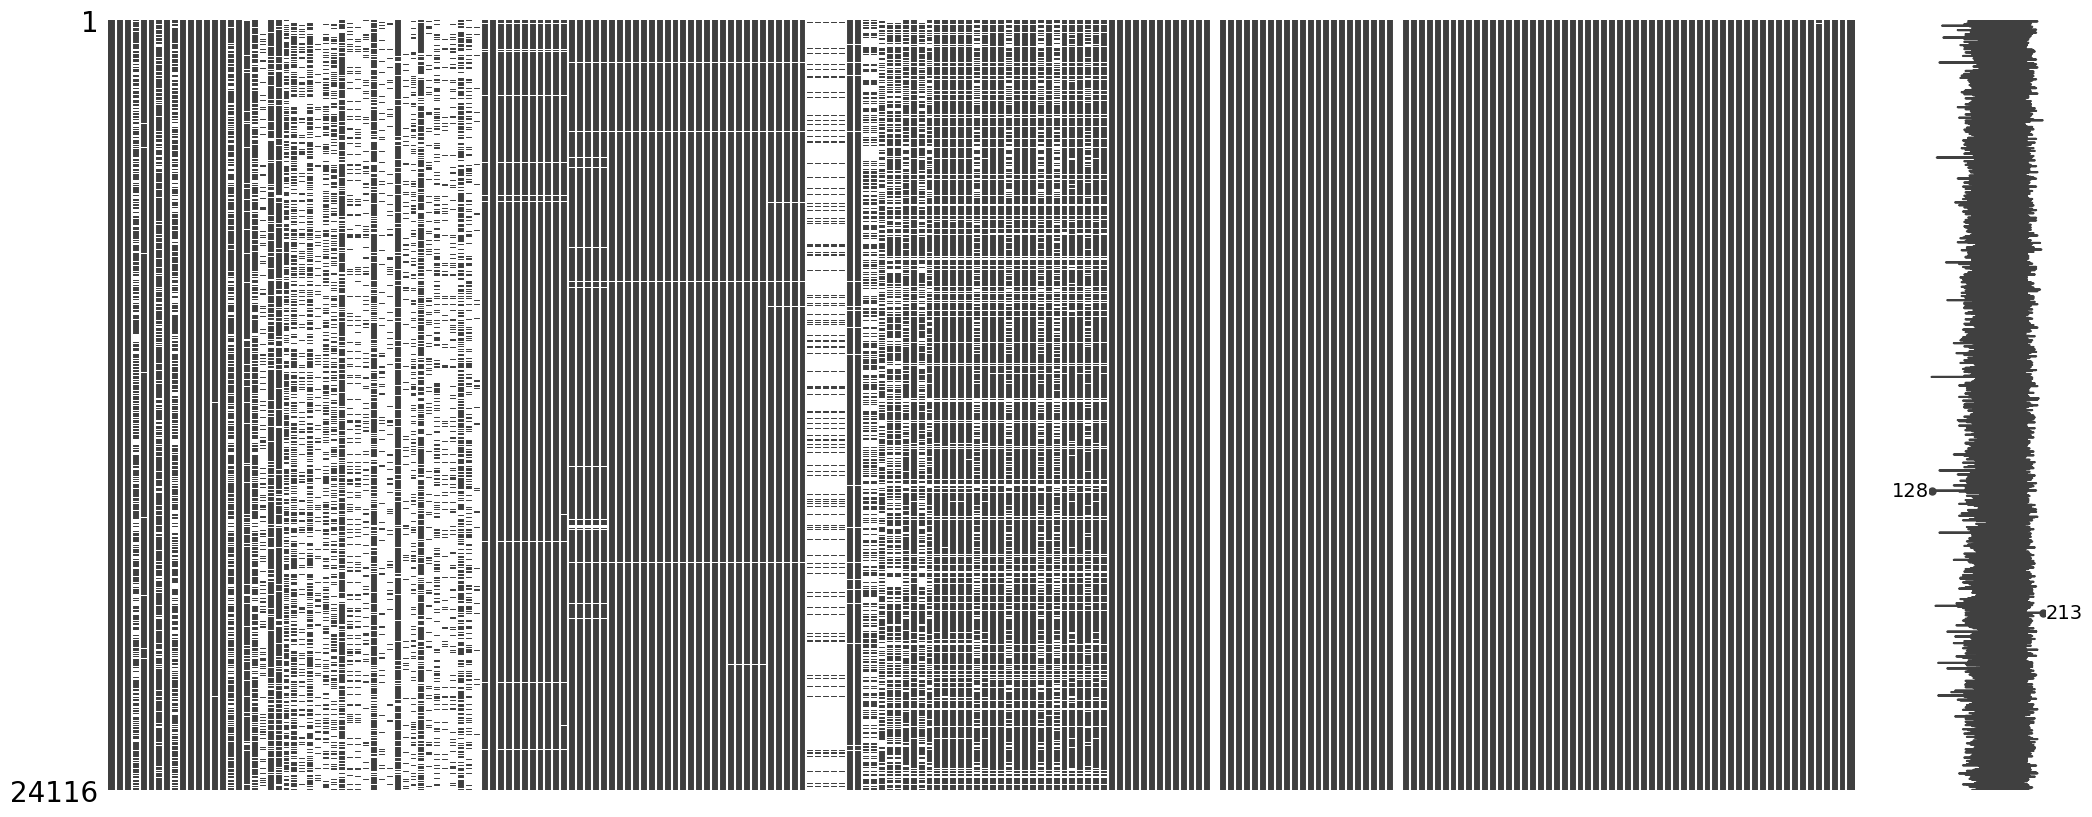

In [12]:
sample_size = int(0.3*len(dat))
sampled_data = dat.sample(sample_size)
msno.matrix(sampled_data)

Each row in the matrix visualization corresponds to a data entry and each column corresponds to a feature.White lines represent missing values and black lines represent non-missing values.

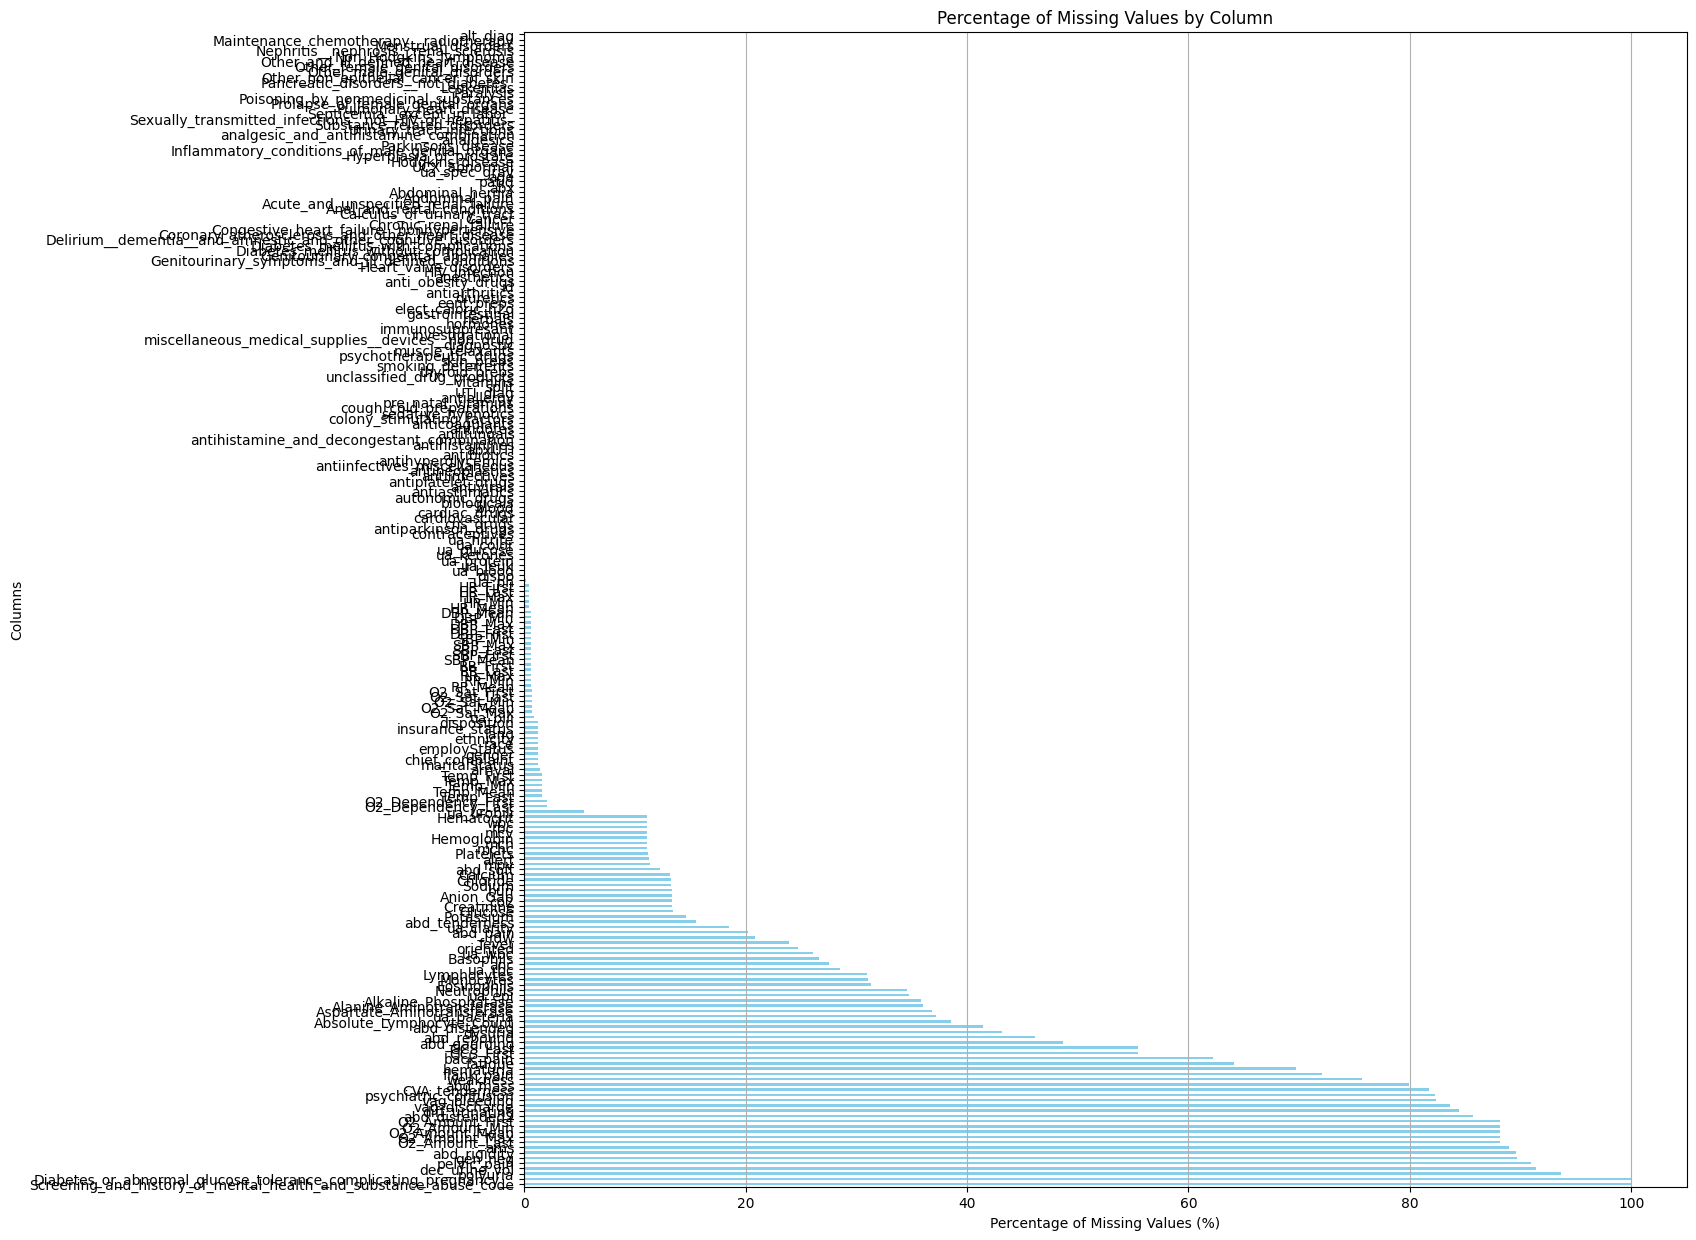

In [13]:
# Compute the percentage of missing values for each column in the sampled data
missing_percentage = (sampled_data.isnull().sum() / len(sampled_data)) * 100
# Sort columns by their missing percentage for better visualization
missing_percentage_sorted = missing_percentage.sort_values(ascending=False)
# Visualize the missing data using a bar chart
plt.figure(figsize=(15, 15))
missing_percentage_sorted.plot(kind='barh', color='skyblue')
plt.xlabel('Percentage of Missing Values (%)')
plt.ylabel('Columns')
plt.title('Percentage of Missing Values by Column')
plt.grid(axis='x')

# Display the visualization
plt.show();

Some columns have a significant amount of missing data.

<AxesSubplot:>

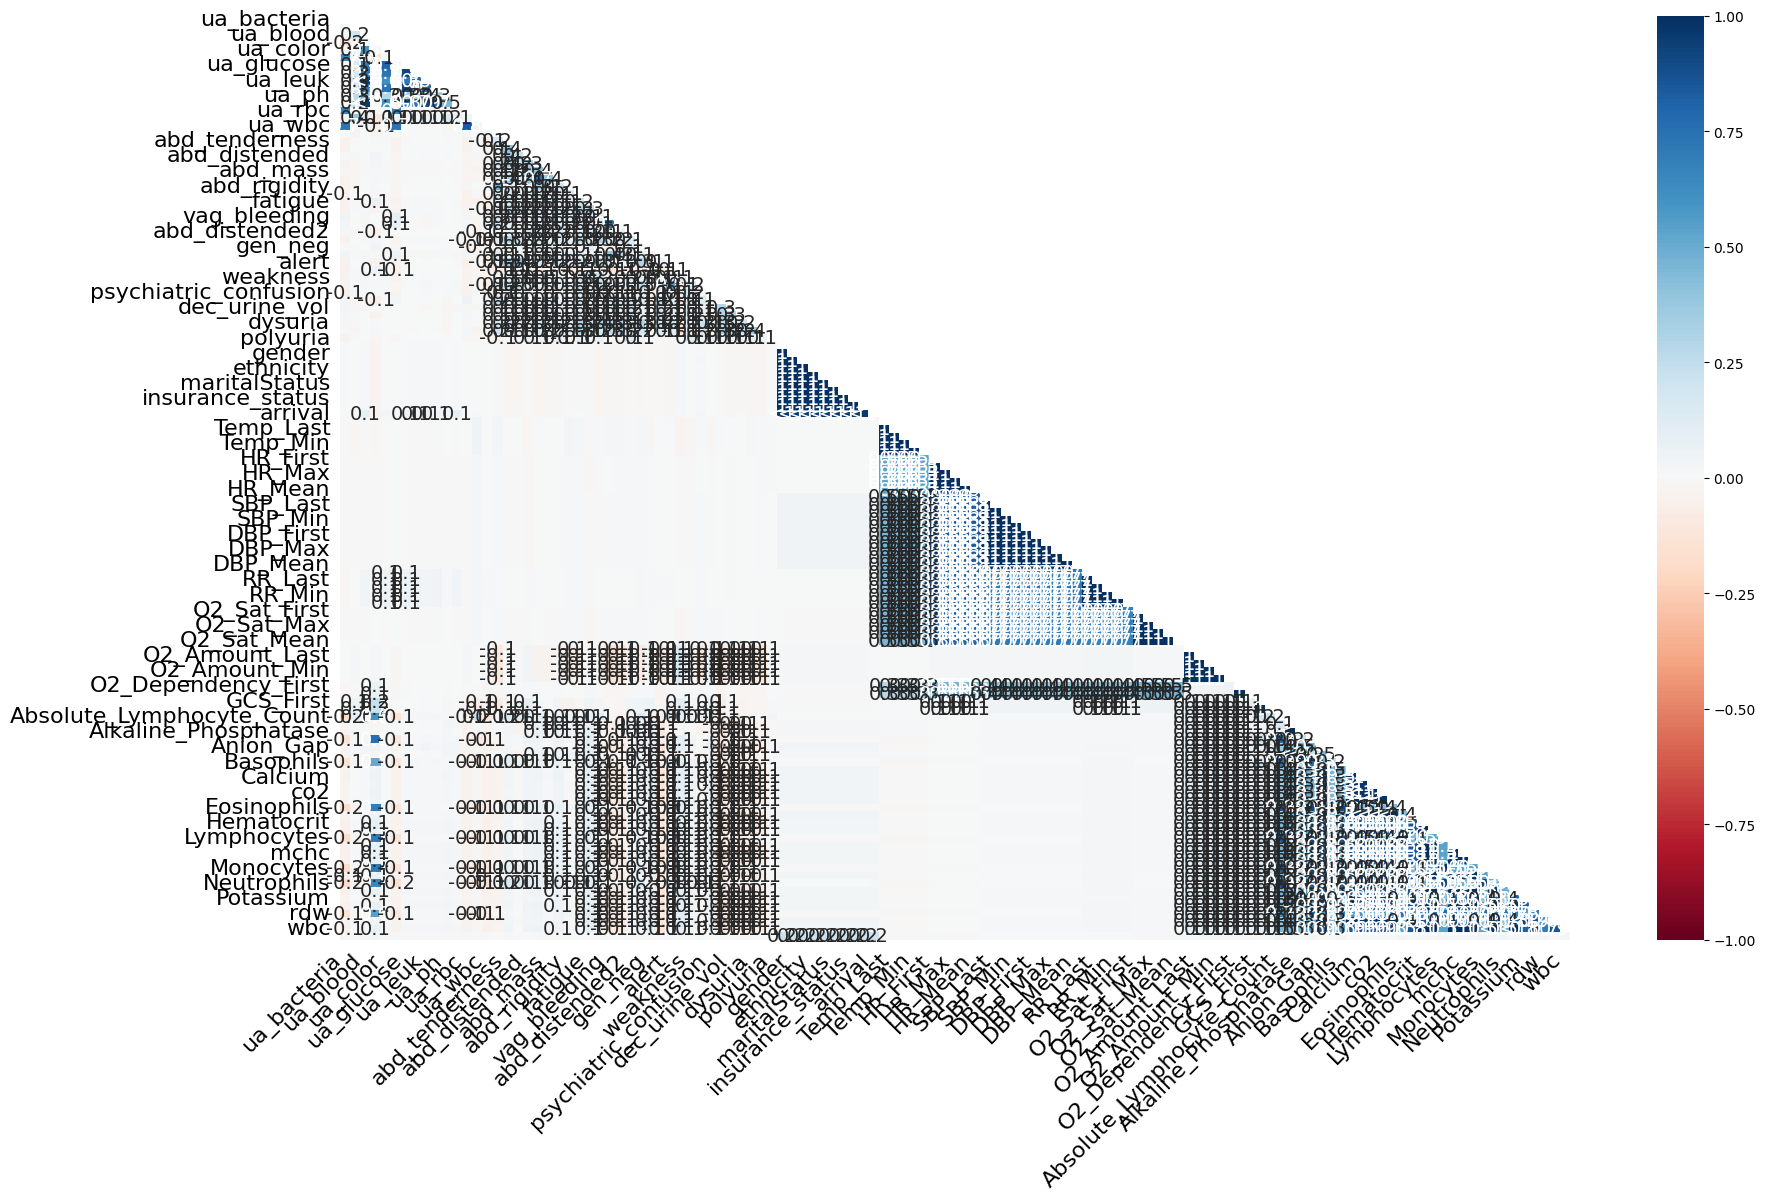

In [14]:
msno.heatmap(dat)

Some columns appear to have no missing values (fully light-colored vertical bands). Some columns have sporadic missing values (columns with intermittent dark spots). A few columns have a significant number of missing values (darker vertical bands). The obtained output image being almost entirely white indicates that there is very low or virtually no missing value correlation between the variables in the dataset.

<AxesSubplot:>

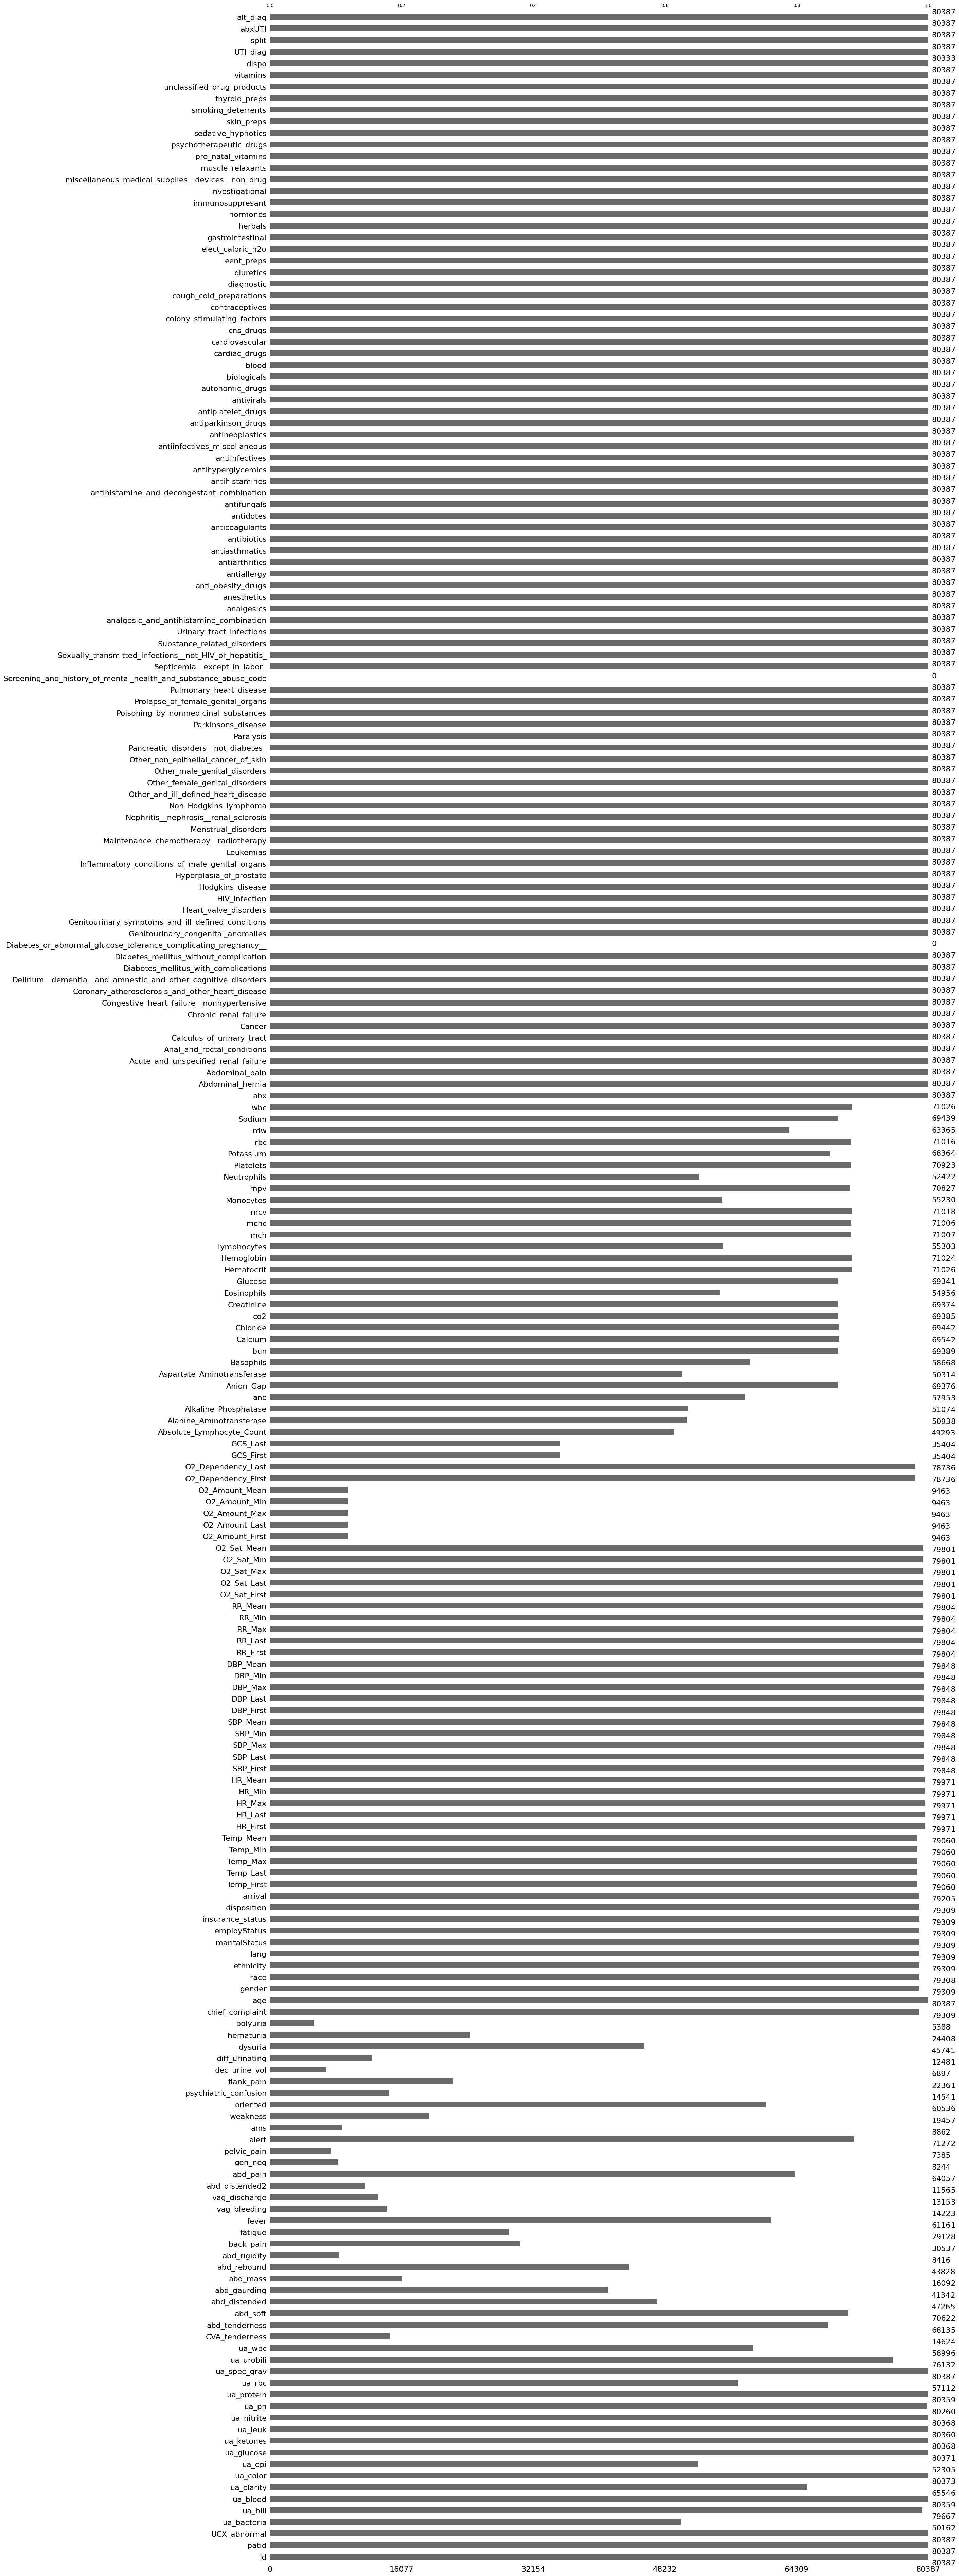

In [15]:
sample_size = int(len(dat))
msno.bar(dat.sample(sample_size))

From the illustration, it is evident that the columns "Screening_and_history_of_mental_health_and_substance_abuse_code" and "Diabetes_or_abnormal_glucose_tolerance_complicating_pregnancy__" have no values. We only retain the columns with less than 10% missing values.

In [16]:
missing_percentage = dat.isnull().mean()
cols_to_keep = missing_percentage[missing_percentage <= 0.1].index
df_new = dat[cols_to_keep]
print(df_new.columns)

Index(['id', 'patid', 'UCX_abnormal', 'ua_bili', 'ua_blood', 'ua_color',
       'ua_glucose', 'ua_ketones', 'ua_leuk', 'ua_nitrite',
       ...
       'skin_preps', 'smoking_deterrents', 'thyroid_preps',
       'unclassified_drug_products', 'vitamins', 'dispo', 'UTI_diag', 'split',
       'abxUTI', 'alt_diag'],
      dtype='object', length=149)


In [17]:
df_new.columns[100:149]

Index(['antiallergy', 'antiarthritics', 'antiasthmatics', 'antibiotics',
       'anticoagulants', 'antidotes', 'antifungals',
       'antihistamine_and_decongestant_combination', 'antihistamines',
       'antihyperglycemics', 'antiinfectives', 'antiinfectives_miscellaneous',
       'antineoplastics', 'antiparkinson_drugs', 'antiplatelet_drugs',
       'antivirals', 'autonomic_drugs', 'biologicals', 'blood',
       'cardiac_drugs', 'cardiovascular', 'cns_drugs',
       'colony_stimulating_factors', 'contraceptives',
       'cough_cold_preparations', 'diagnostic', 'diuretics', 'eent_preps',
       'elect_caloric_h2o', 'gastrointestinal', 'herbals', 'hormones',
       'immunosuppresant', 'investigational',
       'miscellaneous_medical_supplies__devices__non_drug', 'muscle_relaxants',
       'pre_natal_vitamins', 'psychotherapeutic_drugs', 'sedative_hypnotics',
       'skin_preps', 'smoking_deterrents', 'thyroid_preps',
       'unclassified_drug_products', 'vitamins', 'dispo', 'UTI_diag',

<AxesSubplot:>

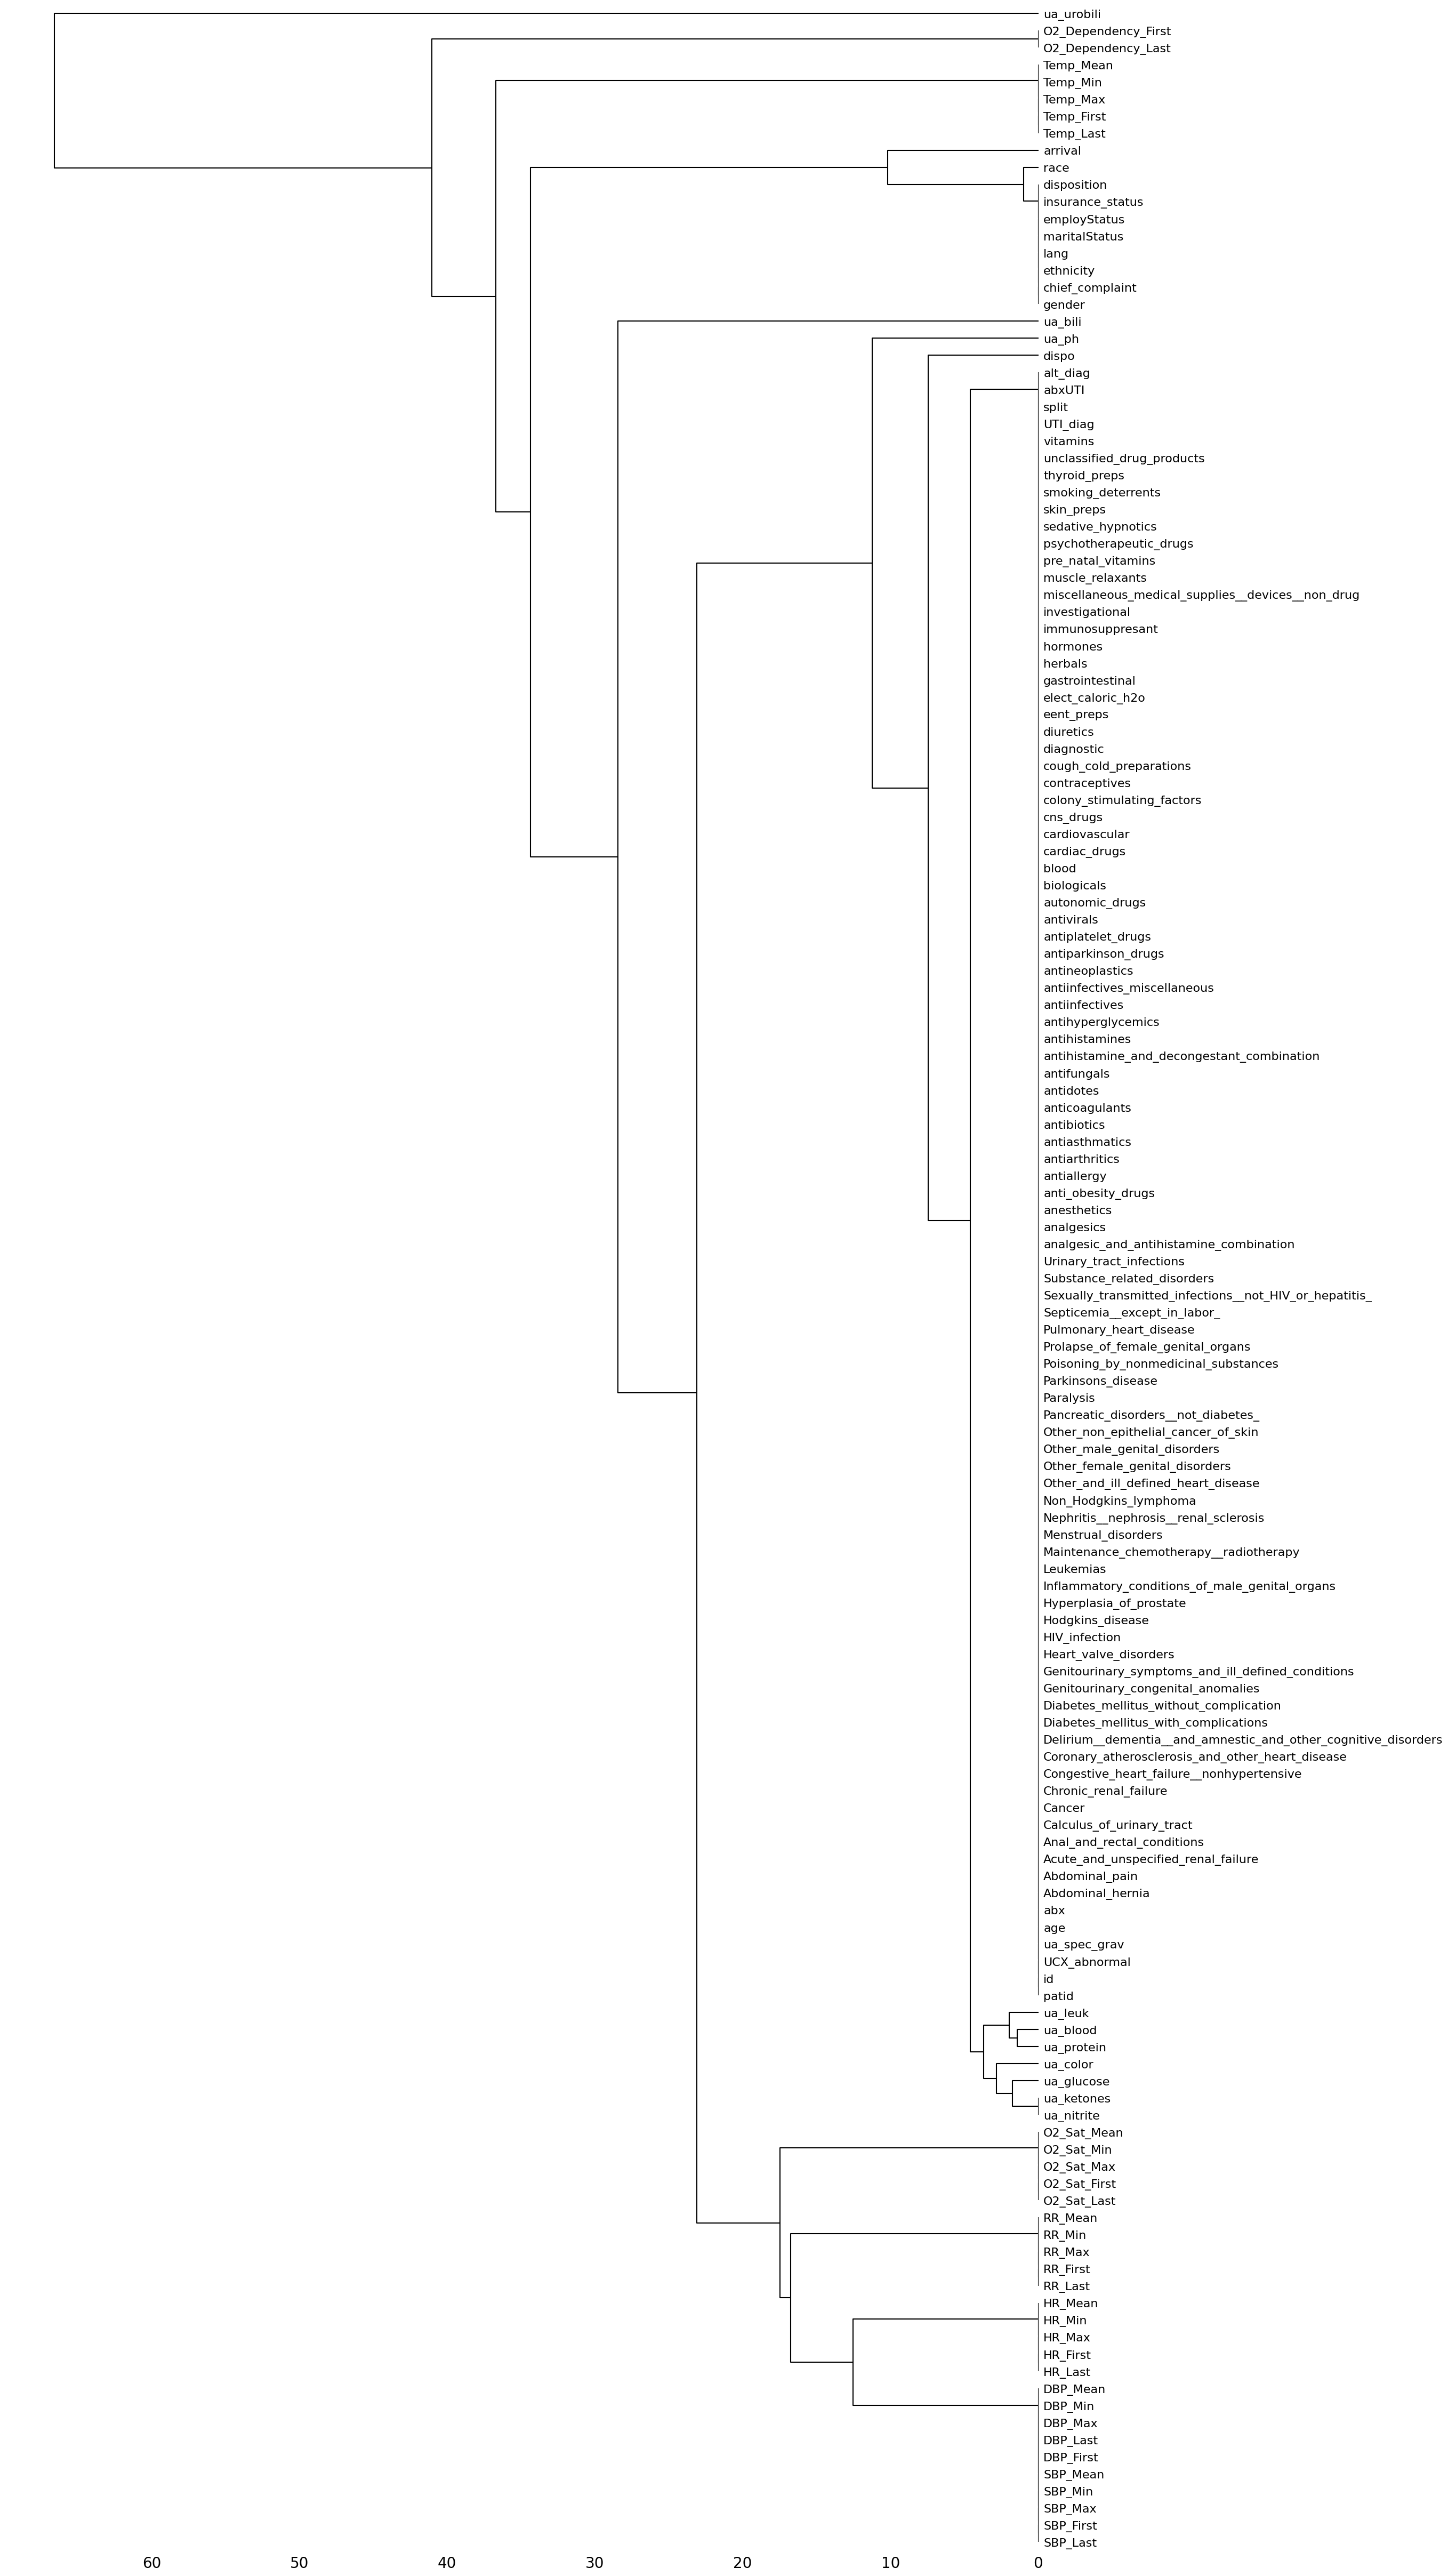

In [18]:
msno.dendrogram(df_new)

The dendrogram visualizes the correlation of missing values between different columns in the df_new dataframe. Several columns cluster together at low distances, indicating a correlation in their missingness patterns.

In [19]:
# Fill missing values in numerical columns with their mean
for col in df_new.select_dtypes(include=[np.number]).columns:
    df_new[col].fillna(df_new[col].mean(), inplace=True)

# Fill missing values in categorical columns with their mode
for col in df_new.select_dtypes(include=[np.object]).columns:
    df_new[col].fillna(df_new[col].mode()[0], inplace=True)

# Verify if there are any missing values left
missing_values_after_fill = df_new.isnull().sum().sum()
missing_values_after_fill

D:\anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\Users\wyr19\AppData\Local\Temp\ipykernel_27880\1689750426.py:6: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  for col in df_new.select_dtypes(include=[np.object]).columns:


0

In [20]:
df_new.to_csv("./datavi.csv", index=False)

## Features selected

Numerical columns are filled with their mean, while categorical columns are filled with their mode

Given the vast number of columns in our dataset, we've chosen to prioritize and select only a few based on their significance. Here's our selection:

1. **'UCX_abnormal'**: This is an indicator determining whether a urinary culture is abnormal or not.
2. **'age'**: Age, being a fundamental demographic factor, has the potential to influence health outcomes.
3. **'gender'**: Gender can play a role in medical outcomes and may interact with other variables.
4. **'race' and 'ethnicity'**: These factors are essential for studies on health disparities and for understanding patterns within specific population groups.
5. **'Temp_Mean', 'HR_Mean', 'SBP_Mean', 'DBP_Mean', 'RR_Mean', 'O2_Sat_Mean'**: These represent the average vital signs, crucial for understanding a patient's overall health status.
6. **'abx'**: This indicates whether antibiotics were administered. Considering UTIs are bacterial infections, this variable provides insights into the treatment patterns.
7. **'UTI_diag'**: It signifies whether a UTI diagnosis was given. Its distribution and relation with other variables can offer insights into diagnostic patterns.
8. **'dispo'**: The patient's disposition, such as discharge or admission, can shed light on the disease's severity or the level of concern.
9. **'ua_bili', 'ua_blood', 'ua_glucose',...**: These are results from urine analyses. They can provide insights into the nature of urinary findings and their relationship with UTI outcomes.
10. **'chief_complaint'**: The primary reason the patient sought medical care can give context about the patient's condition."
11. **Urinary Tract Infections (UTIs)**: UTIs are common infections that pose diagnostic challenges due to reliance on indirect symptoms and tests.
12. **Genitourinary Congenital Anomalies**: These are birth abnormalities that can increase susceptibility to urinary issues or infections. 
13. **Genitourinary Symptoms and Ill-Defined Conditions**: These encompass vague urinary symptoms that complicate precise diagnosis.
14. **Calculus of Urinary Tract**: Urinary stones, though distinct, can present with symptoms overlapping with UTIs, making differentiation vital.

Given the structure and the nature of the data in these columns, let's move on to the visualization phase. Here's the plan:

1. **Bar Plots**: For categorical variables like UCX_abnormal, gender, race, ethnicity, abx, UTI_diag, and dispo.
2. **Histograms and Box Plots**: For numerical variables like age, Temp_Mean, HR_Mean, SBP_Mean, DBP_Mean, RR_Mean, and O2_Sat_Mean.
3. **Special Consideration**: For chief_complaint since it's a textual column, we'll visualize the top complaints using a bar plot.

Let's start with the bar plots for categorical variables.​

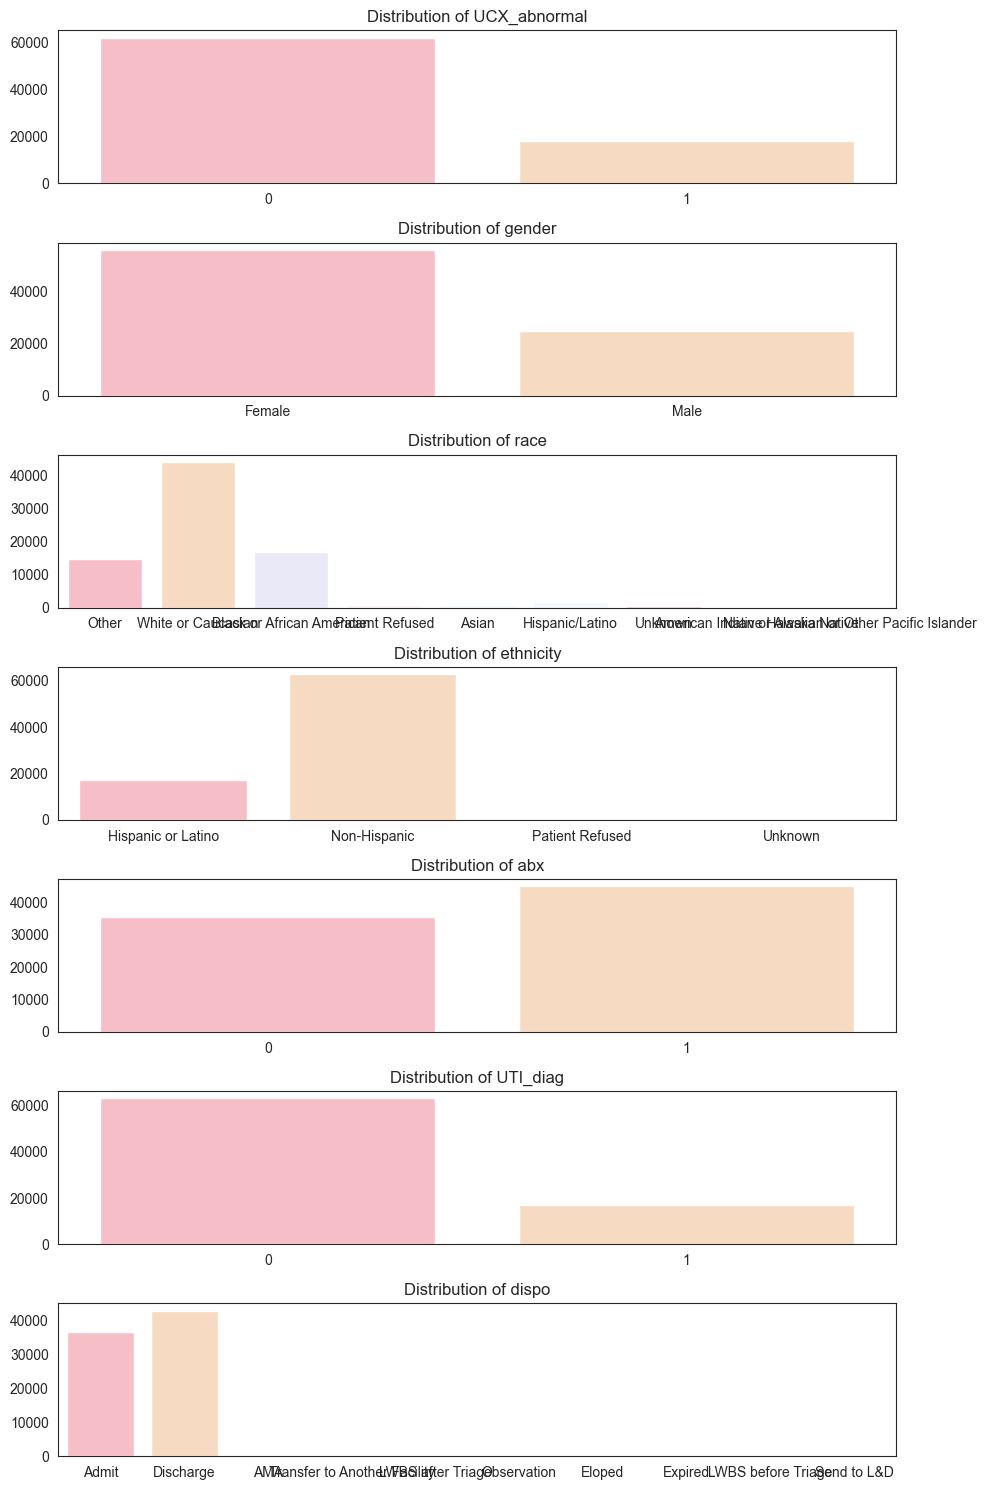

In [21]:
# Set the aesthetic style of the plots
sns.set_style("white")

# Define the columns for bar plots
categorical_cols = ['UCX_abnormal', 'gender', 'race', 'ethnicity', 'abx', 'UTI_diag', 'dispo']

palette = sns.color_palette(["#FFB6C1", "#FFDAB9", "#E6E6FA", "#FFF0F5", "#F0FFF0", "#F0F8FF"])

# Plotting
fig, axes = plt.subplots(nrows=len(categorical_cols), figsize=(10, 15))

for i, col in enumerate(categorical_cols):
    sns.countplot(data=df_new, x=col, ax=axes[i], palette=palette)  # 使用自定义调色板
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show();

In the dataset, most of the data points for UCX_abnormal have a value of 0, indicating no abnormality, yet a significant portion reflects a value of 1, pointing to an abnormality. When examining gender distribution, there's a notable predominance of females over males. As for race, the majority identify as "White or Caucasian", with "Black or African American" being the next most common category. Ethnicity-wise, most individuals are classified as "Non-Hispanic". Interestingly, a significant portion of entries, specifically in the 'abx' category, have a value of 1, suggesting that antibiotics were administered. Lastly, in terms of disposition, a higher number of patients were discharged compared to other categories.

Next, let's visualize the distribution of numerical columns using histograms and box plots.

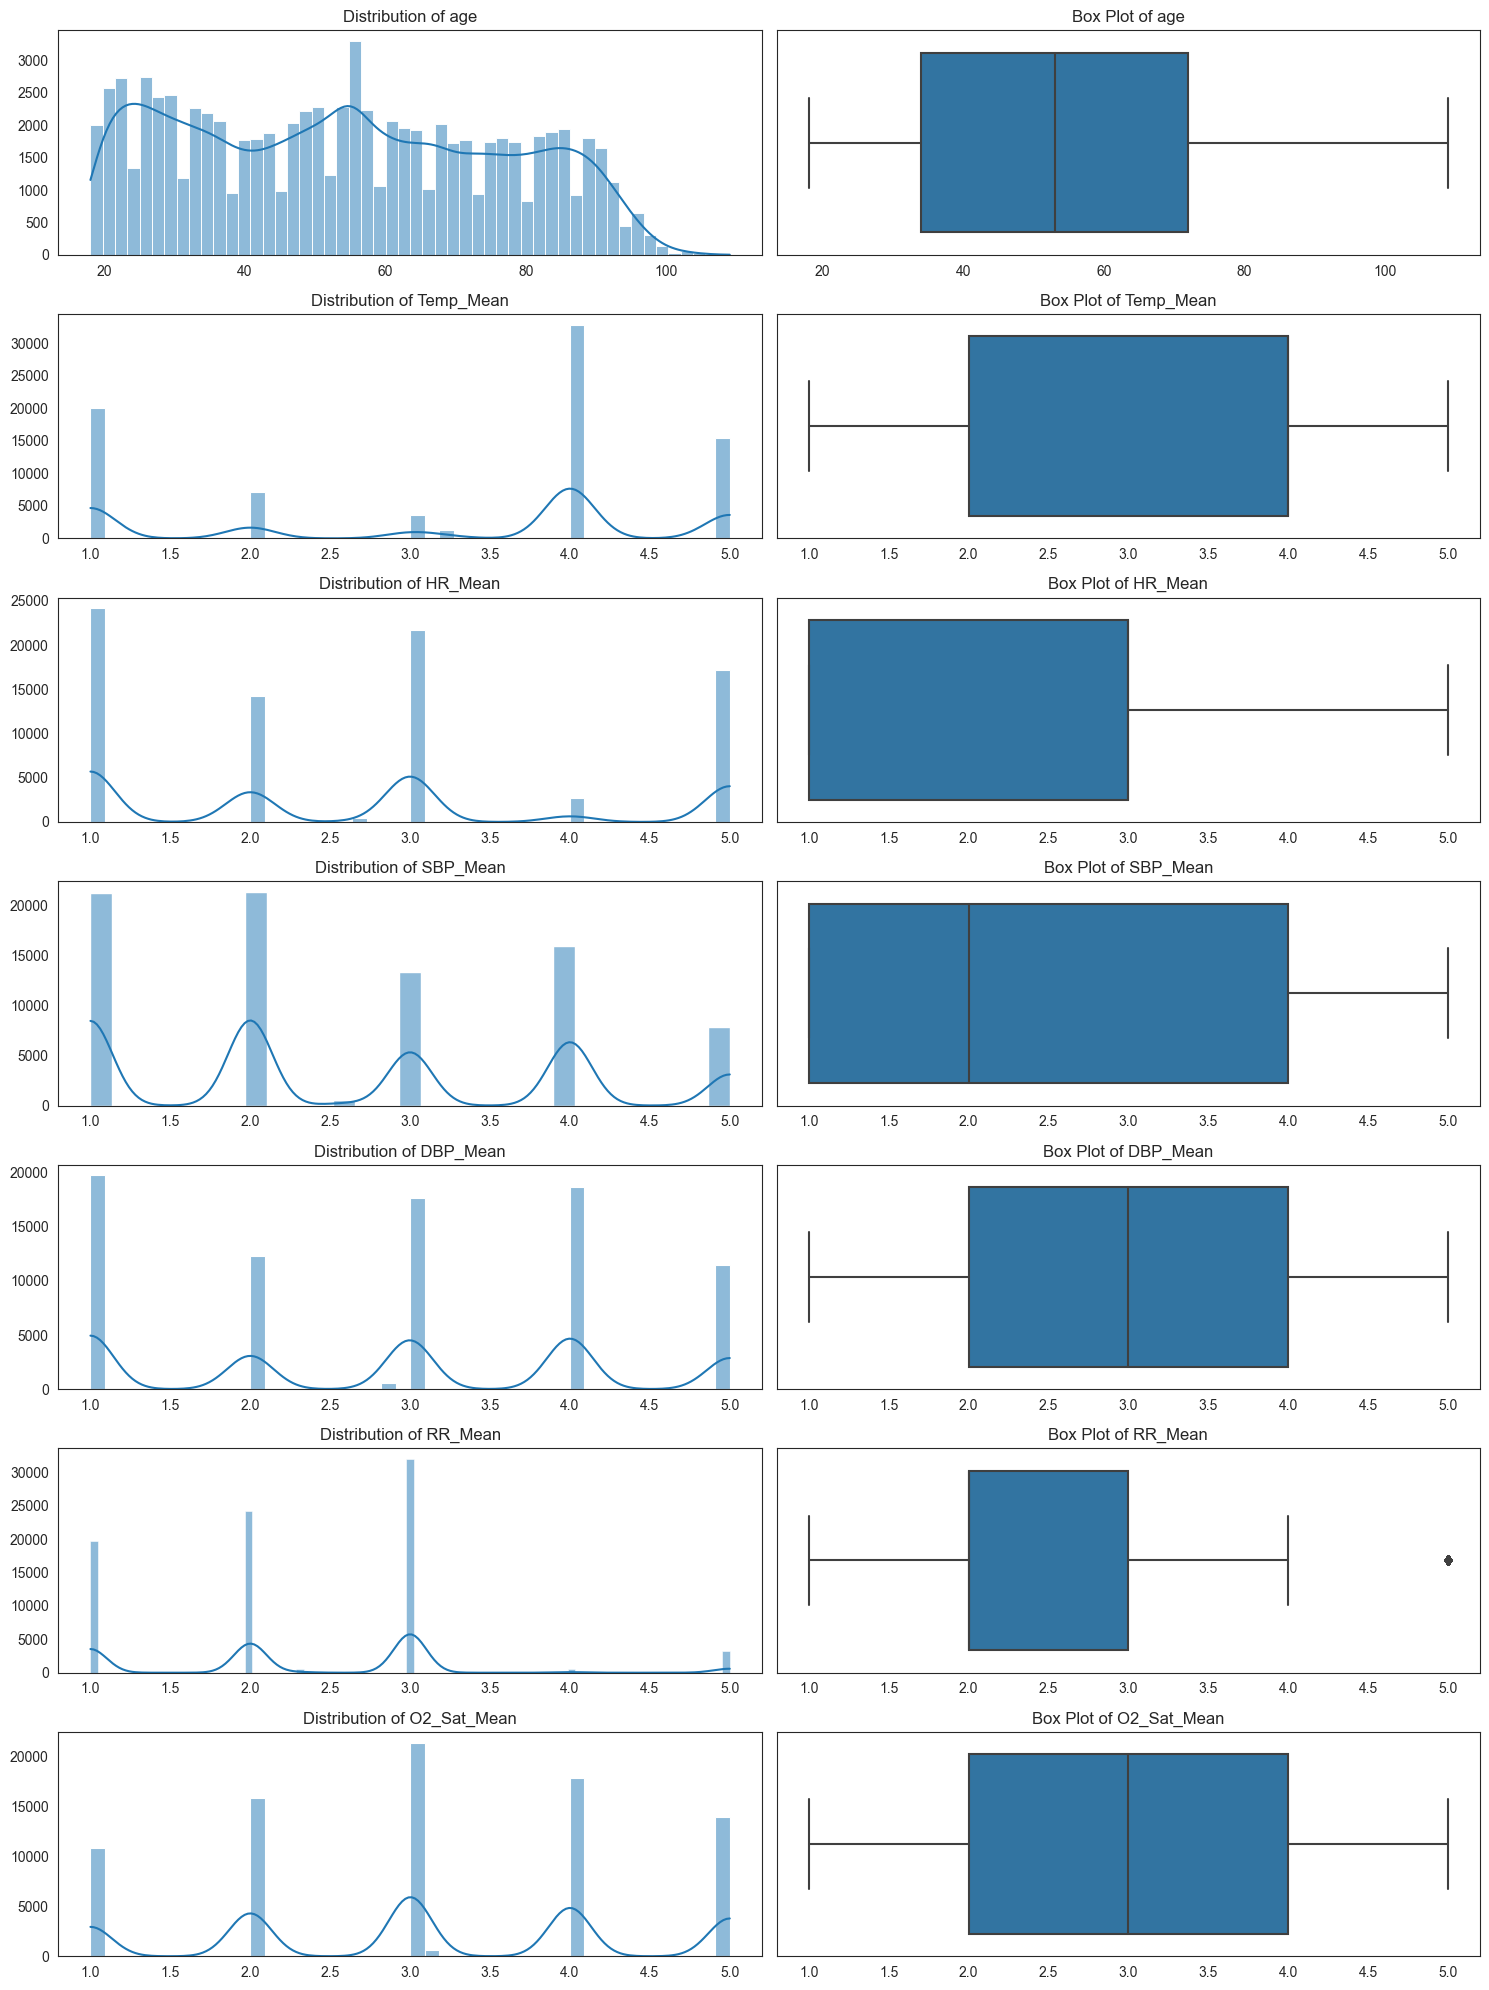

In [22]:
# Define the columns for histograms and boxplots
numerical_cols = ['age', 'Temp_Mean', 'HR_Mean', 'SBP_Mean', 'DBP_Mean', 'RR_Mean', 'O2_Sat_Mean']

# Plotting histograms
fig, axes = plt.subplots(nrows=len(numerical_cols), ncols=2, figsize=(15, 20))

for i, col in enumerate(numerical_cols):
    sns.histplot(data=df_new, x=col, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribution of {col}')
    axes[i, 0].set_xlabel('')
    axes[i, 0].set_ylabel('')

    sns.boxplot(data=df_new, x=col, ax=axes[i, 1])
    axes[i, 1].set_title(f'Box Plot of {col}')
    axes[i, 1].set_xlabel('')
    axes[i, 1].set_ylabel('')

plt.tight_layout()
plt.show();

The distribution of ages in the dataset leans slightly to the right, suggesting a concentration of older individuals. This observation is further validated by the box plot, which reveals a higher median age. Turning our attention to vital sign measurements, such as Temp_Mean, HR_Mean, SBP_Mean, DBP_Mean, RR_Mean, and O2_Sat_Mean, we see distinct patterns for each. For instance, Temp_Mean exhibits a multimodal distribution, hinting at specific temperature values that occur more frequently. HR_Mean generally follows a normal distribution. On the other hand, SBP_Mean and DBP_Mean, representing systolic and diastolic blood pressures respectively, both display right-skewed distributions. RR_Mean, which denotes the respiratory rate, again mirrors a somewhat normal distribution. Lastly, O2_Sat_Mean, which measures oxygen saturation levels, is characterized by a left-skewed distribution.

Next, let's visualize the chief_complaint column. Given that this is a textual column, we'll visualize the top complaints using a bar plot.​

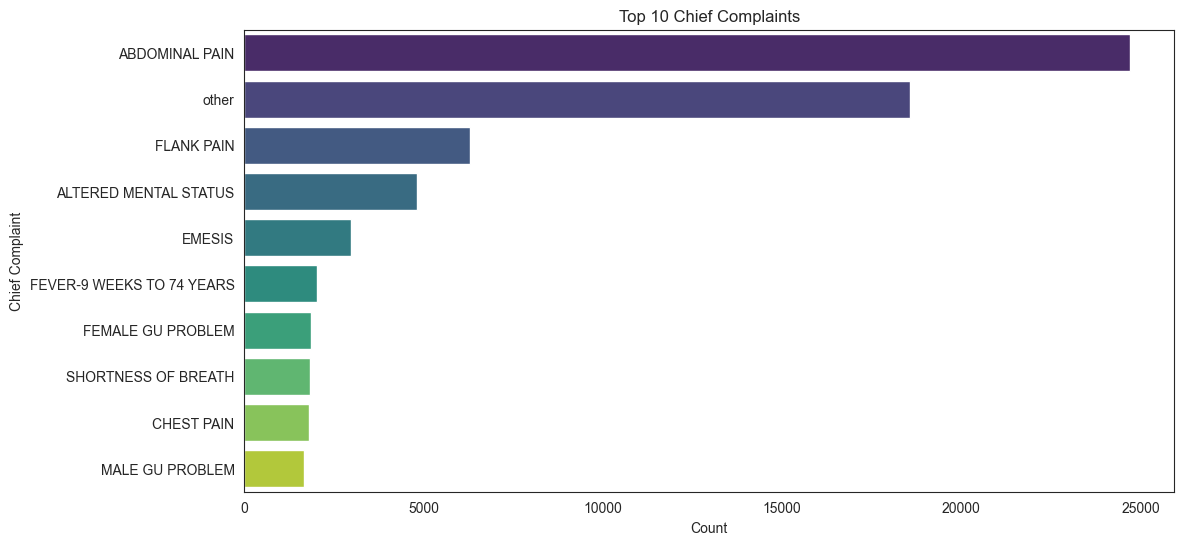

In [23]:
top_complaints = df_new['chief_complaint'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(y=top_complaints.index, x=top_complaints.values, palette="viridis")
plt.title('Top 10 Chief Complaints')
plt.xlabel('Count')
plt.ylabel('Chief Complaint')
plt.show();

The chief complaints from patients predominantly revolve around "Abdominal Pain", which significantly outnumbers other issues. Following this, "Flank Pain" and "Other" emerge as the next two prevalent concerns, with the latter slightly trailing the former. Other complaints like "Altered Mental Status", "Emesis", "Fever-9 Weeks To 74 Years", and "Female Gu Problem" exhibit comparable frequencies, underscoring their recurring but lesser prominence than the leading three. Although "Shortness of Breath", "Chest Pain", and "Male Gu Problem" are among the top ten complaints, they are less frequent in comparison. Overall, this data paints a vivid picture of the primary urinary-related concerns that drive patient visits, with "Abdominal Pain", "Flank Pain", and "Other" standing out as the most significant within the dataset's scope.

We're about to delve into a visualization of select columns from our dataset, namely: 'ua_bili', 'ua_blood', 'ua_color', 'ua_glucose', 'ua_ketones', 'ua_leuk', 'ua_nitrite', 'ua_ph', 'ua_protein', 'ua_spec_grav', 'ua_urobili'.   
These columns, rooted in standard urine analysis, offer a panoramic insight into the various elements commonly present in urine and their clinical implications. For instance, bilirubin levels serve as a barometer for liver health, and its detection in urine can flag potential liver complications. Even trace amounts of blood in urine can allude to infections or more grave issues like tumors. The hue of urine acts as a straightforward gauge of its concentration and can highlight potential health anomalies. Glucose concentrations play a pivotal role in detecting disorders like diabetes. The presence of ketones, typically observed when the body metabolizes fat, can suggest either starvation or a diabetic's inefficient insulin utilization. The enzyme Leukocyte esterase, when detected, is indicative of urinary tract infections—a sentiment echoed by a positive nitrite test, given that specific bacteria transform body nitrates into nitrites. The urine's pH level sheds light on its acidic or alkaline nature, aiding in diagnosing conditions like kidney stones or UTIs. Elevated protein concentrations can be a harbinger of kidney ailments, and the specific gravity of the urine provides a snapshot of an individual's hydration level and kidney efficacy. Urobilinogen levels, derived from bilirubin breakdown, can offer insights into liver functionality and the rate of red blood cell degradation. Collectively, these columns paint a comprehensive picture of an individual's urinary health, serving as a window into their broader well-being.

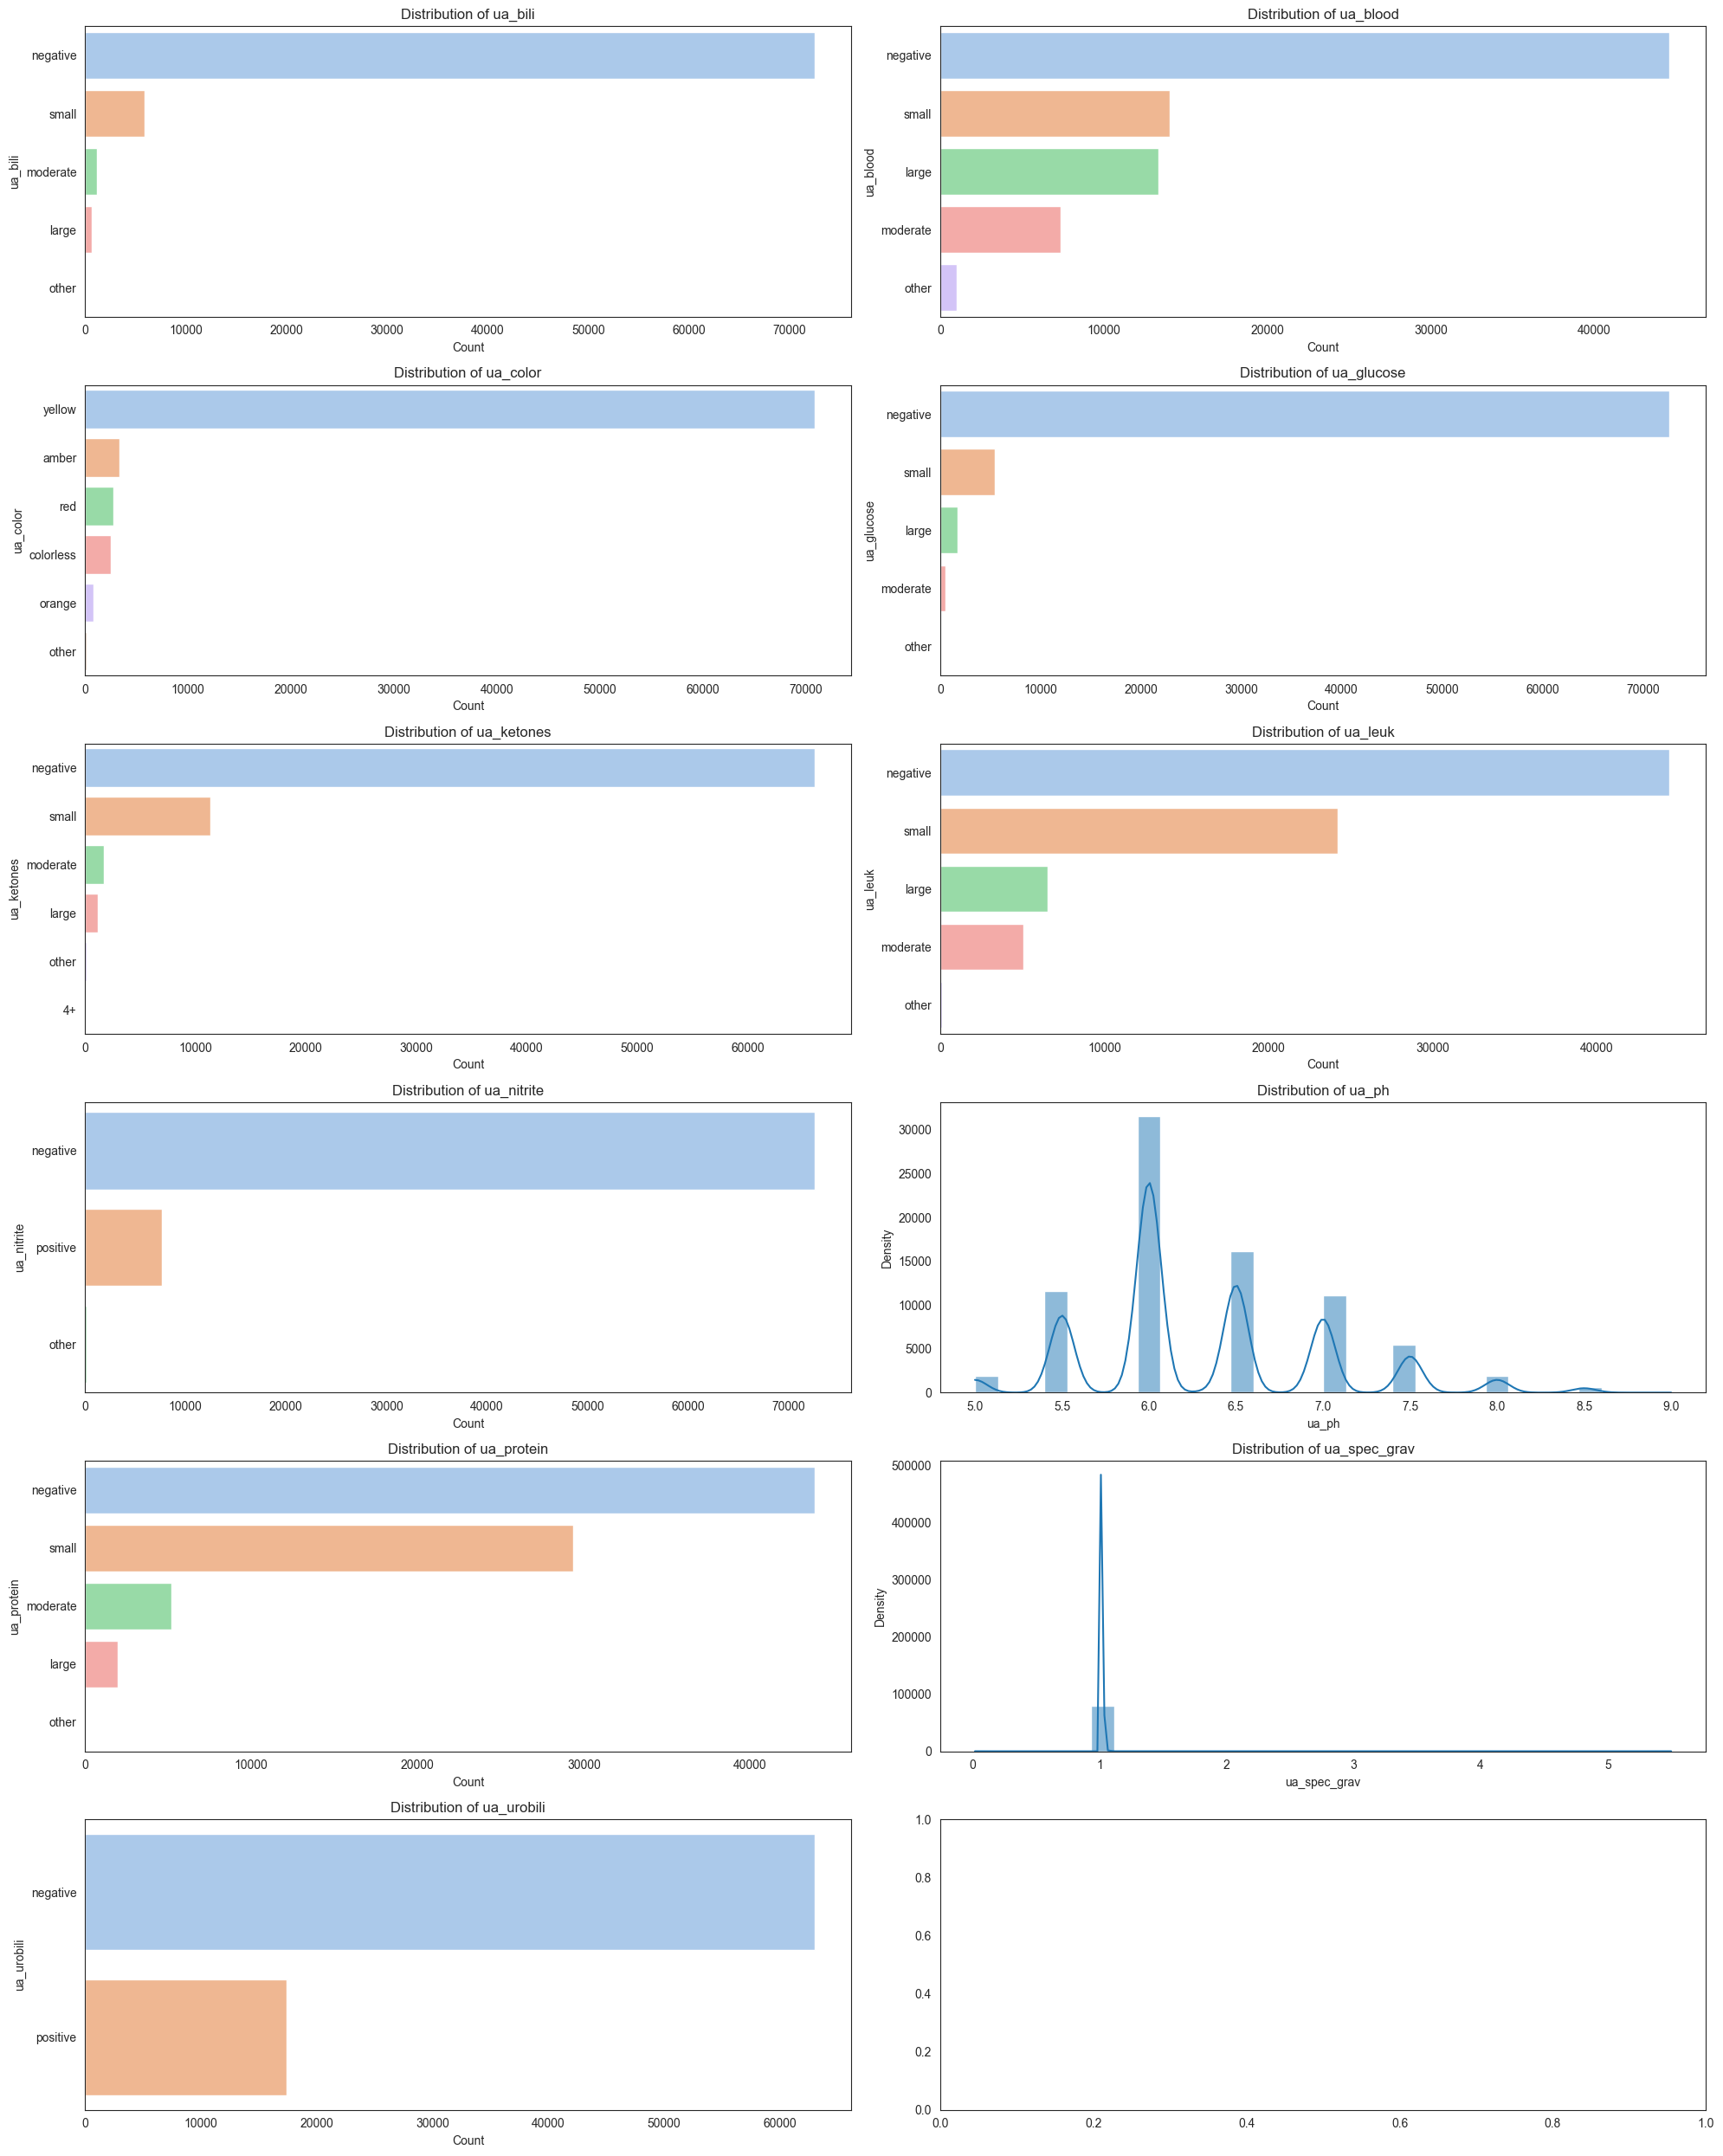

In [24]:
# Set up the figure and axis
fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(20, 25))

# List of columns to visualize
columns_to_visualize = ['ua_bili', 'ua_blood', 'ua_color', 'ua_glucose', 
                        'ua_ketones', 'ua_leuk', 'ua_nitrite', 'ua_ph', 
                        'ua_protein', 'ua_spec_grav', 'ua_urobili']

# Loop through each column and plot the distribution
for i, col in enumerate(columns_to_visualize):
    # Bar plots for categorical variables
    if df_new[col].dtype == 'object':
        sns.countplot(data=df_new, y=col, ax=axs[i//2][i%2],palette="pastel",order=df_new[col].value_counts().index)
        axs[i//2][i%2].set_title(f'Distribution of {col}')
        axs[i//2][i%2].set_xlabel('Count')
    # Histogram for continuous variables
    else:
        sns.histplot(df_new[col], ax=axs[i//2][i%2], bins=30, kde=True,palette="pastel")
        axs[i//2][i%2].set_title(f'Distribution of {col}')
        axs[i//2][i%2].set_ylabel('Density')

# Adjust layout
plt.tight_layout()
plt.show();

From the visualizations, it's evident that the urine samples predominantly exhibited standard characteristics. Most tests for Bilirubin, Glucose, Ketones, Nitrite, and Protein were negative, which means the bulk of the samples did not display issues related to the liver, diabetes, fat metabolism, UTIs, or kidney disease. While most samples did not have blood, a notable portion did show minor amounts, hinting at potential UTIs, kidney stones, or other minor urinary tract bleeding conditions. The color of most samples was typically yellow, though some variations, possibly due to dietary habits, medication, or specific health conditions, were observed. A significant number of samples indicated minor UTIs or infections, as reflected by the results of the Leukocyte Esterase test. The pH levels of the samples were generally centered around 6, despite a broad distribution pointing to diverse diets and hydration statuses. The specific gravity of most samples was around the standard 1.020, suggesting adequate hydration and kidney functionality. Furthermore, the majority of the samples tested negative for Urobilinogen, implying minimal liver issues. While the majority of urine tests seemed to be within normal parameters, exceptions, particularly in the blood and leukocyte esterase results, indicate potential UTIs or other related conditions. Therefore, while interpreting these findings, it's crucial to consider other clinical signs, symptoms, and accompanying tests.

D:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWar

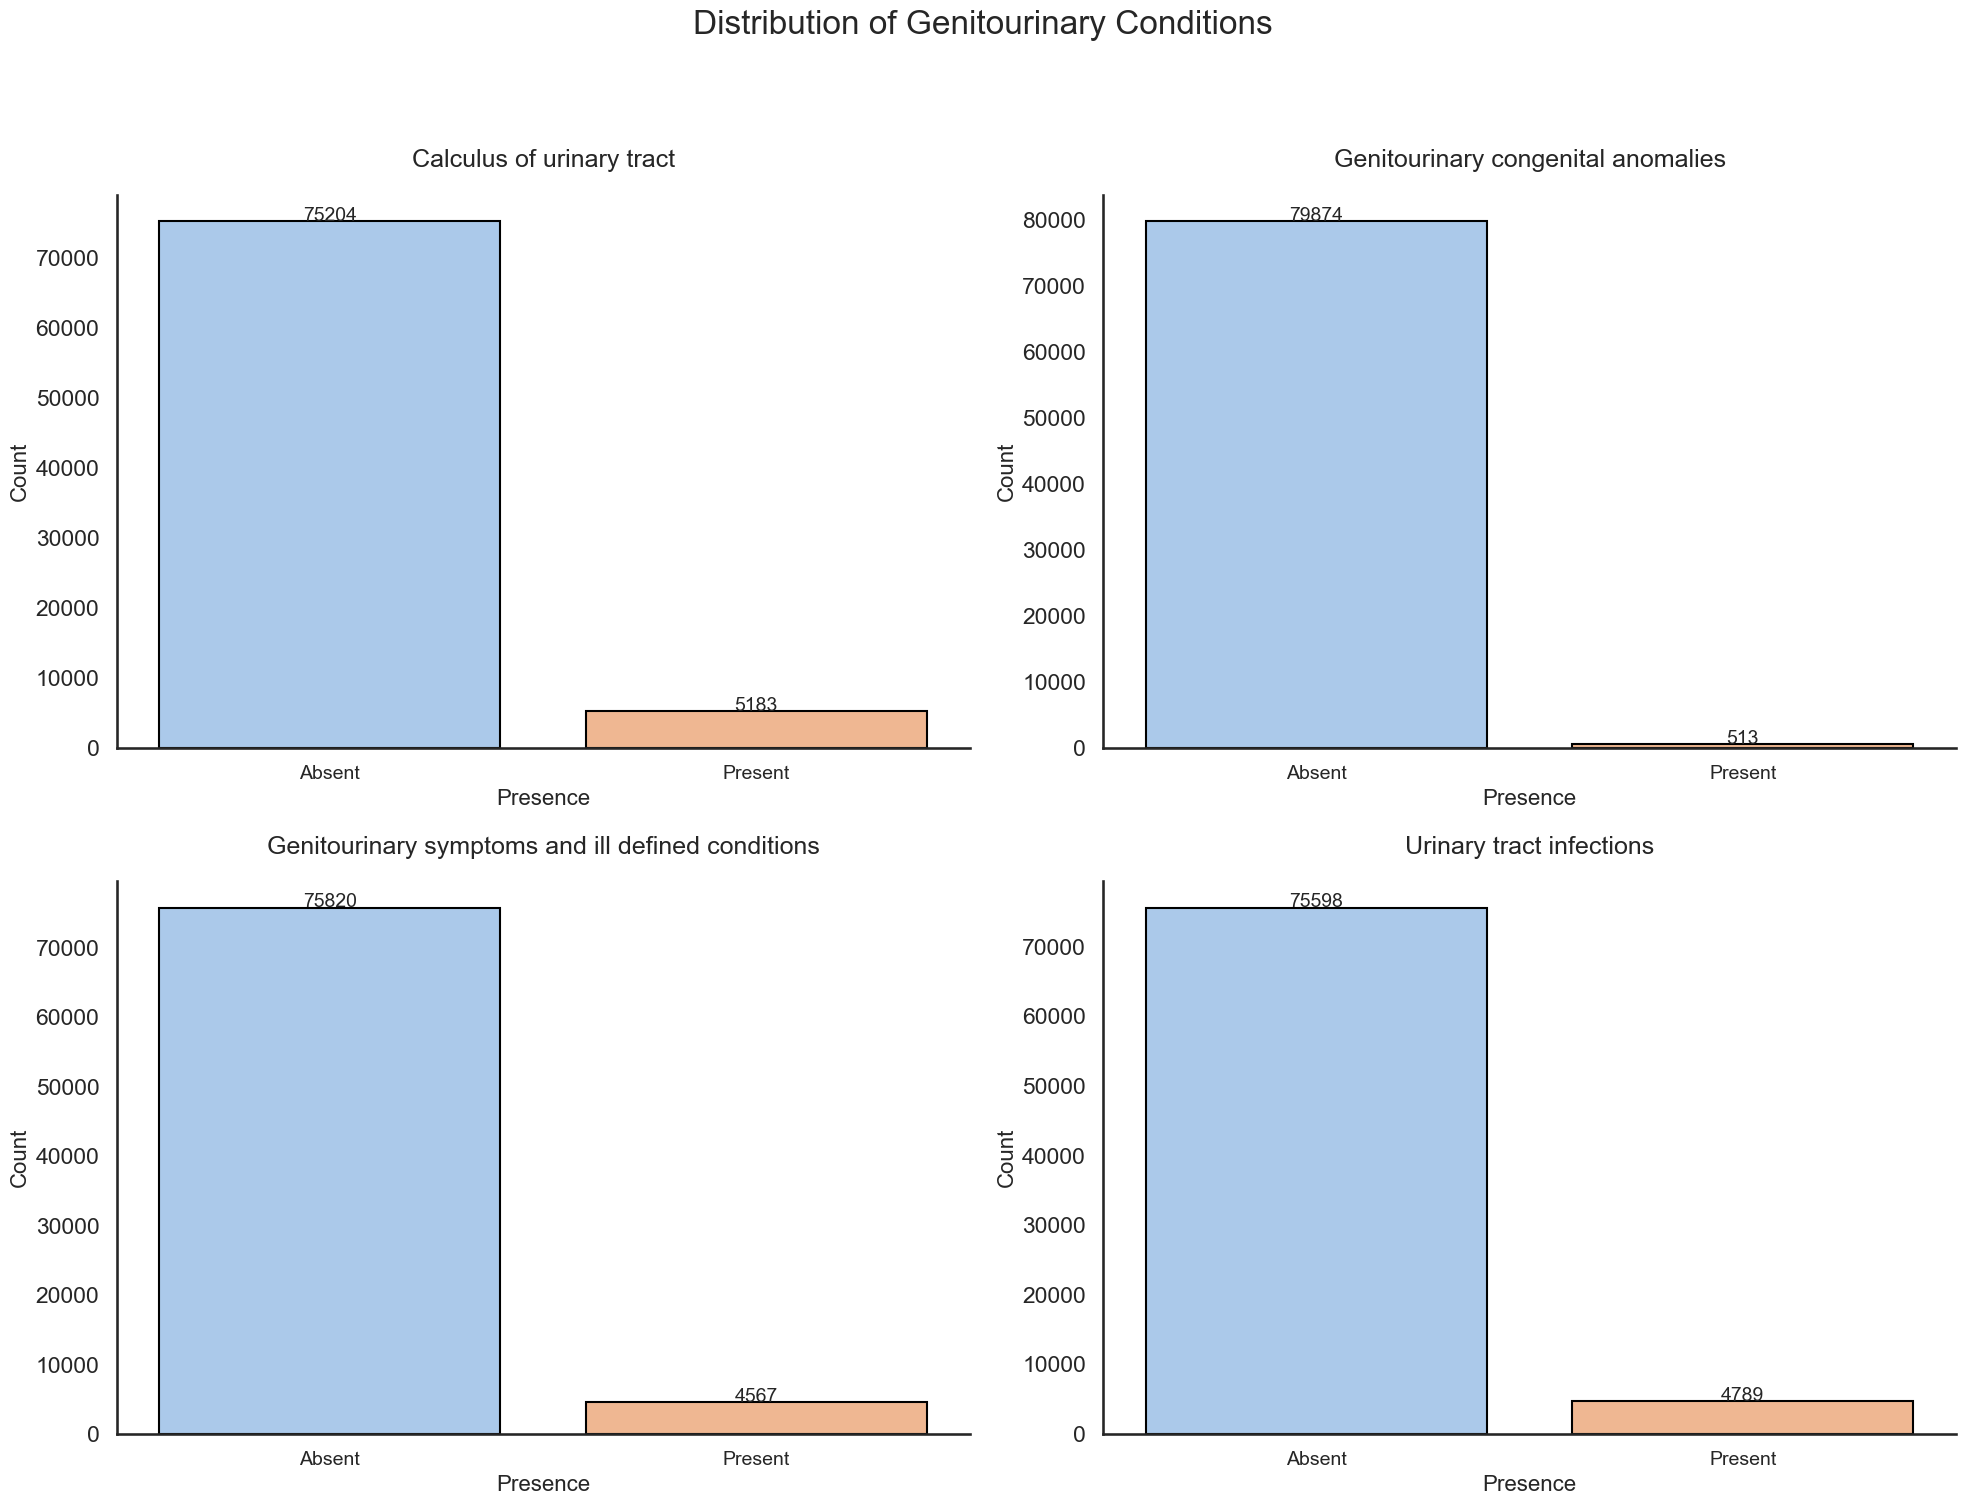

In [25]:
# Set a refined aesthetic for the plots
sns.set_style("white")
sns.set_context("talk")
sns.set_palette("pastel")

# Initialize the figure with a larger size for better clarity
plt.figure(figsize=(20, 14))

cols = ["Calculus_of_urinary_tract","Genitourinary_congenital_anomalies","Genitourinary_symptoms_and_ill_defined_conditions","Urinary_tract_infections"]
# Plotting the data for each column with enhanced aesthetics
for idx, col in enumerate(cols, 1):
    ax = plt.subplot(2, 2, idx)
    
    # Using a barplot to show the distribution
    sns.countplot(df_new[col], ax=ax, edgecolor='black')
    
    # Setting title, labels, and aesthetics
    ax.set_title(col.replace("_", " "), fontsize=18, pad=20)
    ax.set_ylabel("Count", fontsize=16)
    ax.set_xlabel("Presence", fontsize=16)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Absent', 'Present'], fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Displaying the count above the bars
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height + 20,
                '{:1.0f}'.format(height), ha='center', fontsize=14)

plt.tight_layout()
plt.suptitle("Distribution of Genitourinary Conditions", fontsize=24, y=1.08)
plt.show();

the dataset shows the most significant absence of Urinary Tract Infections (UTIs) and Genitourinary Congenital Anomalies, suggesting that these conditions are the least prevalent. In contrast, Calculus of the Urinary Tract (urinary stones) has a relatively higher occurrence, although many entries still lack this condition. While Genitourinary Symptoms and Ill-Defined Conditions rank third in prevalence, their presence remains vital due to the potential diagnostic overlap with UTIs.

## Model Training

In [26]:
features_pre = ['UCX_abnormal', 'gender', 'race', 'ethnicity', 'abx', 'UTI_diag', 'dispo','age', 'Temp_Mean', 
            'HR_Mean', 'SBP_Mean', 'DBP_Mean', 'RR_Mean', 'O2_Sat_Mean', 'ua_bili', 'ua_blood', 'ua_color', 
            'ua_glucose', 'ua_ketones', 'ua_leuk', 'ua_nitrite', 'ua_ph', 'ua_protein', 'ua_spec_grav', 'ua_urobili',
           "Calculus_of_urinary_tract","Genitourinary_congenital_anomalies","Genitourinary_symptoms_and_ill_defined_conditions","Urinary_tract_infections"]
df_features_selected = df_new[features_pre]
df_features_selected.to_csv("./datafeatures.csv", index=False)

split the data manually into 80% training, 10% validation, and 10% testing sets

In [27]:
train_data, temp_data = train_test_split(df_features_selected, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)
len(train_data), len(val_data), len(test_data)

(64309, 8039, 8039)

 training and validating the Random Forest model 

Validation ROC-AUC: 0.882, PR-AUC: 0.640
Test ROC-AUC: 0.882, PR-AUC: 0.619


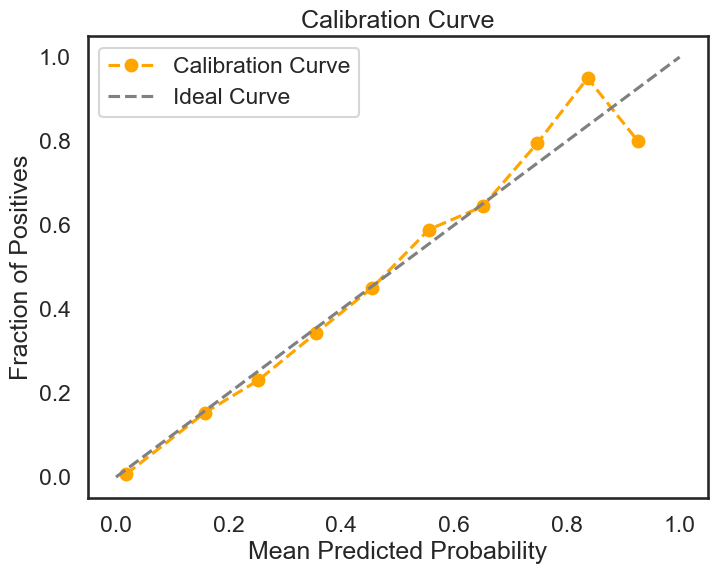

In [28]:
# Define the features and target variable
features = ['UCX_abnormal', 'gender', 'race', 'ethnicity', 'abx', 'dispo', 'age', 'Temp_Mean', 
            'HR_Mean', 'SBP_Mean', 'DBP_Mean', 'RR_Mean', 'O2_Sat_Mean', 'ua_bili', 'ua_blood', 'ua_color', 
            'ua_glucose', 'ua_ketones', 'ua_leuk', 'ua_nitrite', 'ua_ph', 'ua_protein', 'ua_spec_grav', 'ua_urobili',
            "Calculus_of_urinary_tract", "Genitourinary_congenital_anomalies", "Genitourinary_symptoms_and_ill_defined_conditions", "Urinary_tract_infections"]
target = 'UTI_diag'

# Extract features and target variable for training set
X_train = pd.get_dummies(train_data[features], drop_first=True)
y_train = train_data[target]

# Extract features and target variable for validation set
X_val = pd.get_dummies(val_data[features], drop_first=True)
y_val = val_data[target]

# Extract features and target variable for test set
X_test = pd.get_dummies(test_data[features], drop_first=True)
y_test = test_data[target]

# Ensure same set of dummy variables across datasets
missing_cols_val = set(X_train.columns) - set(X_val.columns)
missing_cols_test = set(X_train.columns) - set(X_test.columns)
for col in missing_cols_val:
    X_val[col] = 0
for col in missing_cols_test:
    X_test[col] = 0
X_val = X_val[X_train.columns]
X_test = X_test[X_train.columns]

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict probabilities on validation and test sets
y_val_probs = rf_model.predict_proba(X_val)[:, 1]
y_test_probs = rf_model.predict_proba(X_test)[:, 1]

# Calculate AUC for validation and test sets
roc_auc_val = roc_auc_score(y_val, y_val_probs)
roc_auc_test = roc_auc_score(y_test, y_test_probs)

# Calculate PR-AUC for validation and test sets
pr_auc_val = average_precision_score(y_val, y_val_probs)
pr_auc_test = average_precision_score(y_test, y_test_probs)

# Print the results
print(f"Validation ROC-AUC: {roc_auc_val:.3f}, PR-AUC: {pr_auc_val:.3f}")
print(f"Test ROC-AUC: {roc_auc_test:.3f}, PR-AUC: {pr_auc_test:.3f}")

# Plot Calibration Curves
prob_true, prob_pred = calibration_curve(y_val, y_val_probs, n_bins=10)
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linestyle='--', color='orange', label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Ideal Curve')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend(loc='best')
plt.show();

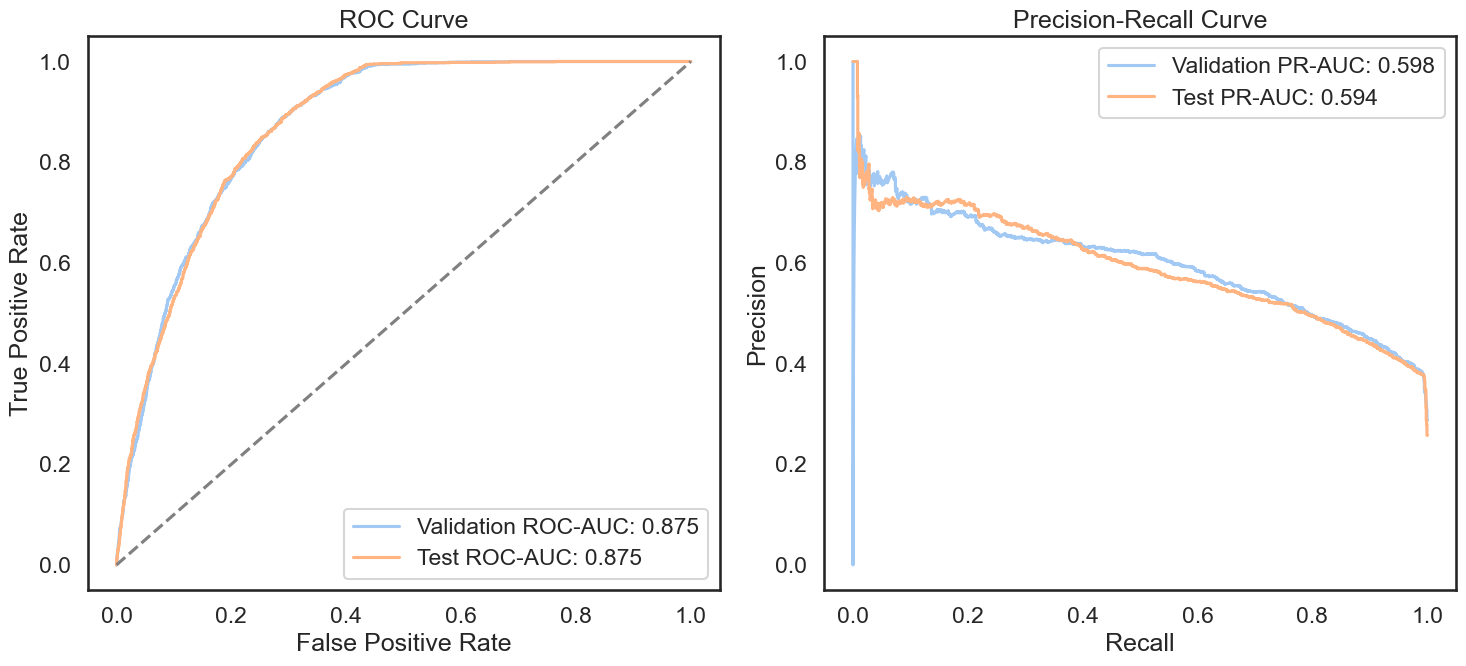

In [36]:
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_probs)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)

precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_probs)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_probs)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

ax[0].plot(fpr_val, tpr_val, label=f'Validation ROC-AUC: {roc_auc_val:.3f}')
ax[0].plot(fpr_test, tpr_test, label=f'Test ROC-AUC: {roc_auc_test:.3f}')
ax[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('ROC Curve')
ax[0].legend()

ax[1].plot(recall_val, precision_val, label=f'Validation PR-AUC: {pr_auc_val:.3f}')
ax[1].plot(recall_test, precision_test, label=f'Test PR-AUC: {pr_auc_test:.3f}')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall Curve')
ax[1].legend()

plt.tight_layout()
plt.show();

The Random Forest model exhibited strong predictive performance across various evaluation metrics. In terms of discrimination ability, the model achieved high ROC-AUC scores of approximately 0.882 on the validation set and also 0.882 on the test set, indicating its excellent ability to distinguish between positive and negative cases. Additionally, the PR-AUC scores, which assess precision-recall trade-offs, were reasonable, with values of approximately 0.64 on the validation set and 0.619 on the test set. Moreover, the calibration curve illustrated that the model's predicted probabilities closely aligned with the ideal curve on the validation set, demonstrating robust calibration. This alignment signifies that the model's probability estimates accurately reflect the true likelihood of UTIs, enhancing its reliability in real-world applications.

training and validating the Logistic Regression model

Validation ROC-AUC: 0.870, PR-AUC: 0.582
Test ROC-AUC: 0.867, PR-AUC: 0.564


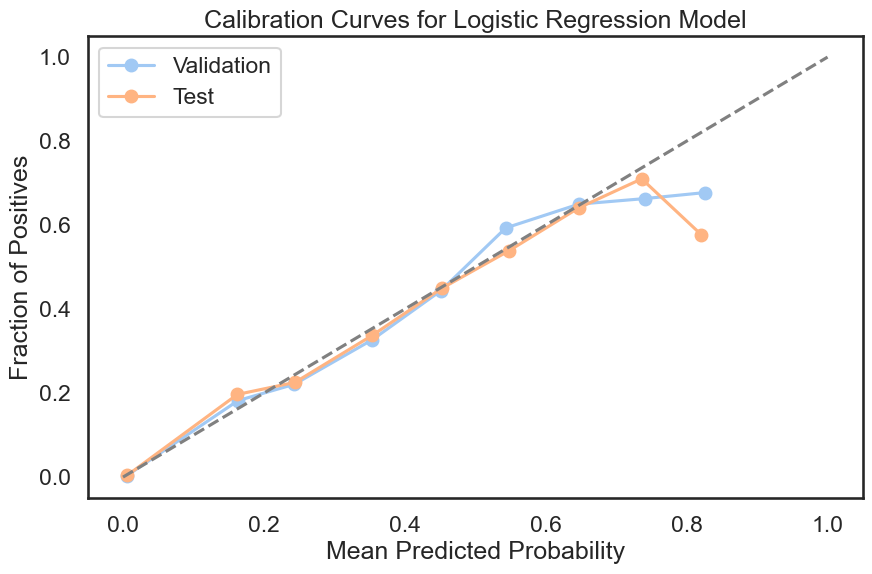

In [38]:
# Features
features = ['UCX_abnormal', 'gender', 'race', 'ethnicity', 'abx', 'dispo','age', 'Temp_Mean', 
            'HR_Mean', 'SBP_Mean', 'DBP_Mean', 'RR_Mean', 'O2_Sat_Mean', 'ua_bili', 'ua_blood', 'ua_color', 
            'ua_glucose', 'ua_ketones', 'ua_leuk', 'ua_nitrite', 'ua_ph', 'ua_protein', 'ua_spec_grav', 'ua_urobili',
           "Calculus_of_urinary_tract","Genitourinary_congenital_anomalies","Genitourinary_symptoms_and_ill_defined_conditions","Urinary_tract_infections"]

# Extracting features and target variable for training, validation, and testing
X_train = pd.get_dummies(train_data[features], drop_first=True)
y_train = train_data['UTI_diag']
X_val = pd.get_dummies(val_data[features], drop_first=True)
y_val = val_data['UTI_diag']
X_test = pd.get_dummies(test_data[features], drop_first=True)
y_test = test_data['UTI_diag']

# Ensure same set of dummy variables across datasets
missing_cols_val = set(X_train.columns) - set(X_val.columns)
missing_cols_test = set(X_train.columns) - set(X_test.columns)
for col in missing_cols_val:
    X_val[col] = 0
for col in missing_cols_test:
    X_test[col] = 0
X_val = X_val[X_train.columns]
X_test = X_test[X_train.columns]

# Train Logistic Regression model
logreg = LogisticRegression(max_iter=1000, solver='liblinear')
logreg.fit(X_train, y_train)

# Predict probabilities on validation and test sets
y_val_probs = logreg.predict_proba(X_val)[:,1]
y_test_probs = logreg.predict_proba(X_test)[:,1]

# Calculate and print AUC and PR-AUC for validation and test sets
roc_auc_val = roc_auc_score(y_val, y_val_probs)
roc_auc_test = roc_auc_score(y_test, y_test_probs)
pr_auc_val = average_precision_score(y_val, y_val_probs)
pr_auc_test = average_precision_score(y_test, y_test_probs)

print(f"Validation ROC-AUC: {roc_auc_val:.3f}, PR-AUC: {pr_auc_val:.3f}")
print(f"Test ROC-AUC: {roc_auc_test:.3f}, PR-AUC: {pr_auc_test:.3f}")

# Plot calibration curves
prob_true_val, prob_pred_val = calibration_curve(y_val, y_val_probs, n_bins=10)
prob_true_test, prob_pred_test = calibration_curve(y_test, y_test_probs, n_bins=10)
plt.figure(figsize=(10, 6))
plt.plot(prob_pred_val, prob_true_val, '-o', label='Validation')
plt.plot(prob_pred_test, prob_true_test, '-o', label='Test')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curves for Logistic Regression Model')
plt.legend()
plt.show();

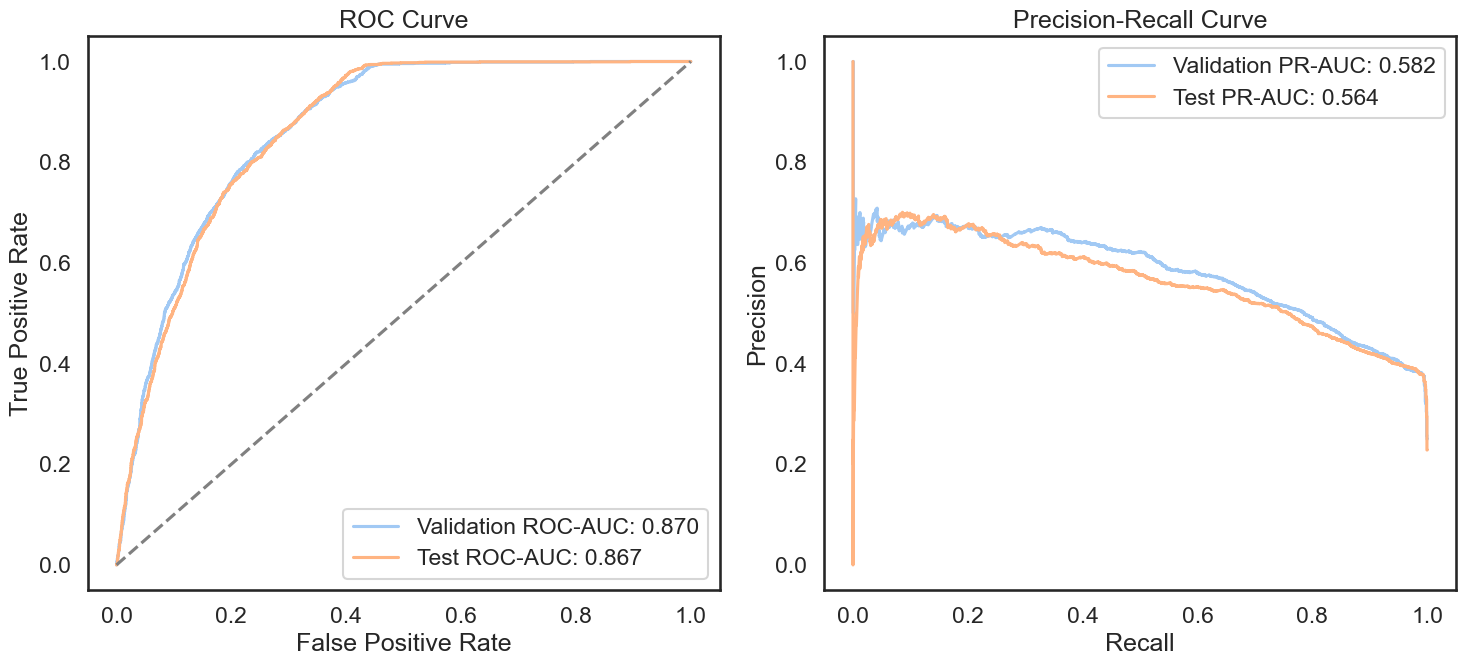

In [39]:
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_probs)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)

precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_probs)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_probs)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

ax[0].plot(fpr_val, tpr_val, label=f'Validation ROC-AUC: {roc_auc_val:.3f}')
ax[0].plot(fpr_test, tpr_test, label=f'Test ROC-AUC: {roc_auc_test:.3f}')
ax[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('ROC Curve')
ax[0].legend()

ax[1].plot(recall_val, precision_val, label=f'Validation PR-AUC: {pr_auc_val:.3f}')
ax[1].plot(recall_test, precision_test, label=f'Test PR-AUC: {pr_auc_test:.3f}')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall Curve')
ax[1].legend()

plt.tight_layout()
plt.show();

The Logistic Regression model yielded promising results in the analysis. It demonstrated good discriminatory power, as indicated by the ROC-AUC values of 0.87 on the validation set and 0.867 on the test set. These values suggest a strong ability to distinguish between positive and negative classes. The PR-AUC values of 0.582 on the validation set and 0.564 on the test set, although moderate, indicate reasonable performance, particularly in imbalanced datasets. Calibration curves revealed that the model is generally well-calibrated, especially for predicted probabilities below 0.6. However, for highly confident predictions (higher probabilities), there is a slight tendency to overestimate the likelihood of the positive class.

Validation ROC-AUC: 0.875, PR-AUC: 0.598
Test ROC-AUC: 0.875, PR-AUC: 0.594


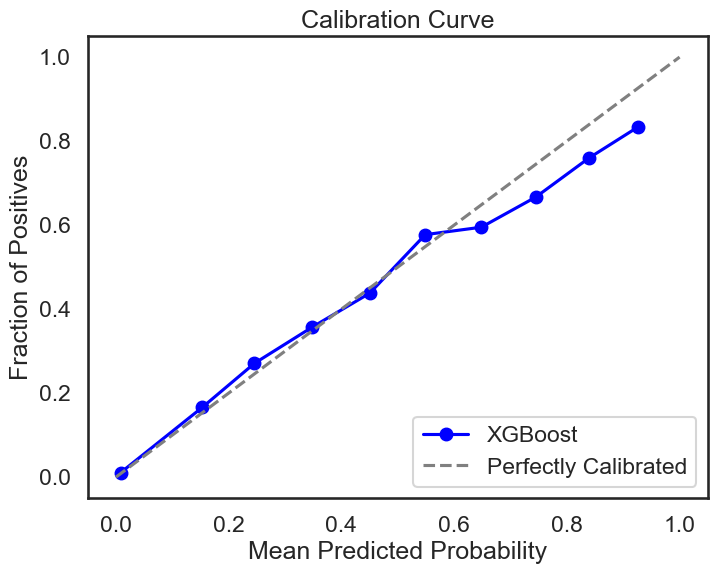

In [40]:
features = ['UCX_abnormal', 'gender', 'race', 'ethnicity', 'abx', 'dispo','age', 'Temp_Mean', 
            'HR_Mean', 'SBP_Mean', 'DBP_Mean', 'RR_Mean', 'O2_Sat_Mean', 'ua_bili', 'ua_blood', 'ua_color', 
            'ua_glucose', 'ua_ketones', 'ua_leuk', 'ua_nitrite', 'ua_ph', 'ua_protein', 'ua_spec_grav', 'ua_urobili',
           "Calculus_of_urinary_tract","Genitourinary_congenital_anomalies","Genitourinary_symptoms_and_ill_defined_conditions","Urinary_tract_infections"]

# Extracting features and target variable for training, validation, and testing
X_train = pd.get_dummies(train_data[features], drop_first=True)
y_train = train_data['UTI_diag']
X_val = pd.get_dummies(val_data[features], drop_first=True)
y_val = val_data['UTI_diag']
X_test = pd.get_dummies(test_data[features], drop_first=True)
y_test = test_data['UTI_diag']

# Ensure same set of dummy variables across datasets
missing_cols_val = set(X_train.columns) - set(X_val.columns)
missing_cols_test = set(X_train.columns) - set(X_test.columns)
for col in missing_cols_val:
    X_val[col] = 0
for col in missing_cols_test:
    X_test[col] = 0
X_val = X_val[X_train.columns]
X_test = X_test[X_train.columns]

# Initialize and train the XGBoost model
xgb_model = XGBClassifier(random_state=42);
xgb_model.fit(X_train, y_train);

# Predict probabilities on the validation and test sets
y_val_probs = xgb_model.predict_proba(X_val)[:, 1]
y_test_probs = xgb_model.predict_proba(X_test)[:, 1]

# Calculate AUC for validation and test sets
roc_auc_val = roc_auc_score(y_val, y_val_probs)
roc_auc_test = roc_auc_score(y_test, y_test_probs)

# Calculate PR-AUC for validation and test sets
pr_auc_val = average_precision_score(y_val, y_val_probs)
pr_auc_test = average_precision_score(y_test, y_test_probs)

# Plot ROC curve for validation and test sets
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_probs)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)

# Print AUC and PR-AUC scores
print(f"Validation ROC-AUC: {roc_auc_val:.3f}, PR-AUC: {pr_auc_val:.3f}")
print(f"Test ROC-AUC: {roc_auc_test:.3f}, PR-AUC: {pr_auc_test:.3f}")

# Compute calibration curve for validation set
prob_true, prob_pred = calibration_curve(y_val, y_val_probs, n_bins=10)

# Create a plot for the calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', color='b', label='XGBoost')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend(loc='lower right')
plt.show();

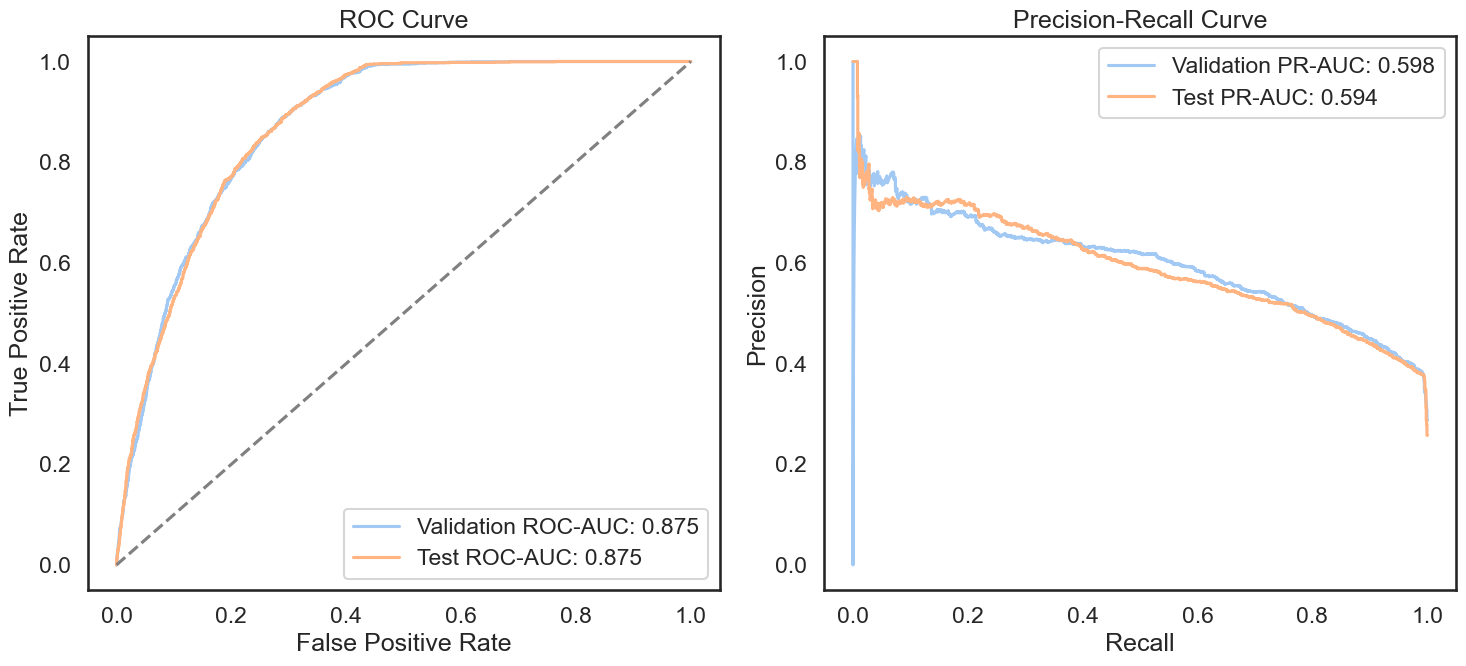

In [41]:
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_probs)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)

precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_probs)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_probs)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

ax[0].plot(fpr_val, tpr_val, label=f'Validation ROC-AUC: {roc_auc_val:.3f}')
ax[0].plot(fpr_test, tpr_test, label=f'Test ROC-AUC: {roc_auc_test:.3f}')
ax[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('ROC Curve')
ax[0].legend()

ax[1].plot(recall_val, precision_val, label=f'Validation PR-AUC: {pr_auc_val:.3f}')
ax[1].plot(recall_test, precision_test, label=f'Test PR-AUC: {pr_auc_test:.3f}')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall Curve')
ax[1].legend()

plt.tight_layout()
plt.show();

The XGBoost model exhibits strong predictive performance with a validation ROC-AUC of 0.875 and a test ROC-AUC of 0.875, indicating its ability to effectively distinguish between positive and negative cases. Furthermore, the model demonstrates reasonable precision-recall trade-off with a validation PR-AUC of 0.598 and a test PR-AUC of 0.594. The calibration curve illustrates that the model's predicted probabilities align well with the actual probabilities of the positive class, suggesting reliable calibration. These results collectively showcase the XGBoost model's effectiveness in predicting UTI diagnoses and its potential for clinical application.

## download dataset

In [31]:
# Step 1: Convert Numbers to Numerics
# Pandas typically auto-detects numeric columns, but we can enforce the conversion for safety
for col in dat.columns:
    try:
        dat[col] = pd.to_numeric(dat[col], errors='ignore')
    except:
        pass
# Step 2: Ensure Strings are Stored as Strings
# Identify non-numeric and non-datetime columns and convert them to strings (object)
non_numeric_cols = dat.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']).columns
dat[non_numeric_cols] = dat[non_numeric_cols].astype(str)
# Step 3: Convert Times to Strings
# Identify datetime columns and convert them to strings
datetime_cols = dat.select_dtypes(include=['datetime64[ns]']).columns
for col in datetime_cols:
    dat[col] = dat[col].astype(str)
dat.to_csv("./dat.csv", index=False)